In [430]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-06-01'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*15)

df = yf.download(tickers = symbols_list, start = start_date, end = end_date).stack()

df.index.names  = ['date', 'ticker']

df.columns = df.columns.str.lower()

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

[*********************100%%**********************]  503 of 503 completed


In [431]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2009-06-05 A        12.992174   14.234621   14.549356   14.127325   14.442060   
           AAL       2.743378    2.910000    2.950000    2.810000    2.900000   
           AAPL      4.442935    5.166786    5.228571    5.114643    5.189643   
           ABT      16.062450   21.581404   21.715748   21.279131   21.547817   
           ACGL      6.580000    6.580000    6.667778    6.553333    6.655556   
...                       ...         ...         ...         ...         ...   
2024-05-31 XYL     141.020004  141.020004  141.389999  138.130005  139.710007   
           YUM     137.429993  137.429993  137.570007  134.800003  135.160004   
           ZBH     115.150002  115.150002  115.190002  113.750000  114.370003   
           ZBRA    312.339996  312.339996  318.769989  308.160004  316.609985   
           ZTS     169.559998  169.559998  172.149994  167.960007  170.000000   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2009-06-05 A         3230359.0         -0.003891        NaN       NaN   
           AAL       7126600.0         -0.000009        NaN       NaN   
           AAPL    632716000.0         -0.009080        NaN       NaN   
           ABT      14827011.0         -0.033136        NaN       NaN   
           ACGL      3825000.0          0.000100        NaN       NaN   
...                        ...               ...        ...       ...   
2024-05-31 XYL       3015200.0          0.000238  57.673999  4.928734   
           YUM       2282900.0          0.000100  49.529719  4.902004   
           ZBH       3003100.0          0.000061  36.877520  4.746815   
           ZBRA       507200.0          0.000502  52.600453  5.740459   
           ZTS       4088400.0          0.000301  52.119439  5.111517   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2009-06-05 A            NaN       NaN       NaN       NaN      41.969387  
           AAL          NaN       NaN       NaN       NaN      19.550955  
           AAPL         NaN       NaN       NaN       NaN    2811.115753  
           ABT          NaN       NaN       NaN       NaN     238.158129  
           ACGL         NaN       NaN       NaN       NaN      25.168500  
...                     ...       ...       ...       ...            ...  
2024-05-31 XYL     4.962701  4.996667  1.175299  1.267798     425.203517  
           YUM     4.930785  4.959565  0.943918 -0.622282     313.738930  
           ZBH     4.787247  4.827678 -0.178021 -1.101762     345.806970  
           ZBRA    5.769188  5.797917  0.523700  0.789539     158.418846  
           ZTS     5.142331  5.173145  1.064747  0.741770     693.229094  

[1798753 rows x 14 columns]

In [432]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data = data.reindex(sorted(data.columns), axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2010-06-30 AAPL      7.724693 -0.768980  2.262196  2.134832  2.198514   
           ABT      17.257856 -0.877189  2.950173  2.883360  2.916766   
           ACN      30.556438 -0.764767  3.490225  3.385657  3.437941   
           ADBE     26.430000 -0.770471  3.591269  3.344119  3.467694   
           AFL      15.961277  0.227960  2.892256  2.786879  2.839567   
...                       ...       ...       ...       ...       ...   
2024-05-31 VZ       41.150002 -0.251395  3.738356  3.682904  3.710630   
           WFC      59.919998  0.215445  4.151741  4.090583  4.121162   
           WMT      65.760002  1.767058  4.230057  4.079567  4.154812   
           XOM     117.260002  1.087514  4.798889  4.735275  4.767082   
           ZTS     169.559998  1.064747  5.173145  5.111517  5.142331   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2010-06-30 AAPL           -0.010847 -0.165262  46.429095  
           ABT            -0.025903 -0.293889  40.766748  
           ACN            -0.024377 -0.172712  48.506352  
           ADBE            0.000458 -0.314167  27.414862  
           AFL            -0.030735 -0.559933  44.559306  
...                             ...       ...        ...  
2024-05-31 VZ              0.000182 -0.037914  57.853275  
           WFC             0.000101 -0.008464  52.151459  
           WMT             0.000250  3.536427  69.819135  
           XOM             0.000173 -0.783627  52.417245  
           ZTS             0.000301  0.741770  52.119439  

[25032 rows x 8 columns]

In [433]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2011-06-30 AAPL     10.308702 -0.794873  2.443886  2.373759  2.408822   
           ABT      20.127739 -1.019176  3.050069  3.016317  3.033193   
           ACN      48.634304 -0.704036  3.898156  3.772552  3.835354   
           ADBE     31.450001 -0.821330  3.536945  3.421811  3.479378   
           AFL      17.854324 -0.655505  2.936714  2.884166  2.910440   
...                       ...       ...       ...       ...       ...   
2024-05-31 VRTX    455.339996  1.776148  6.151800  5.998779  6.075290   
           VZ       41.150002 -0.251395  3.738356  3.682904  3.710630   
           WFC      59.919998  0.215445  4.151741  4.090583  4.121162   
           WMT      65.760002  1.767058  4.230057  4.079567  4.154812   
           XOM     117.260002  1.087514  4.798889  4.735275  4.767082   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2011-06-30 AAPL           -0.008418 -0.238715  51.208525  -0.034960   
           ABT            -0.020198 -0.140363  57.558827   0.007081   
           ACN            -0.016961  0.032954  66.284682   0.052797   
           ADBE            0.000131 -0.237532  45.356321  -0.091828   
           AFL            -0.025922 -0.800401  45.604298  -0.023227   
...                             ...       ...        ...        ...   
2024-05-31 VRTX            0.000231  3.147282  66.970777   0.159186   
           VZ              0.000182 -0.037914  57.853275   0.042036   
           WFC             0.000101 -0.008464  52.151459   0.010115   
           WMT             0.000250  3.536427  69.819135   0.108003   
           XOM             0.000173 -0.783627  52.417245  -0.008540   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2011-06-30 AAPL    -0.020867  -0.012435   0.006662   0.018846    0.024339  
           ABT      0.005557   0.026925   0.018921   0.003807    0.012902  
           ACN      0.028391   0.034800   0.038741   0.041972    0.039489  
           ADBE    -0.031802  -0.017494   0.003595   0.020717    0.014597  
           AFL     -0.086002  -0.038329  -0.029362  -0.009505    0.009384  
...                      ...        ...        ...        ...         ...  
2024-05-31 VRTX     0.043697   0.026693   0.042453   0.030210    0.028878  
           VZ      -0.009699   0.009325   0.011902   0.018214    0.012075  
           WFC      0.016768   0.025318   0.050483   0.042245    0.034662  
           WMT      0.045420   0.039114   0.040248   0.021707    0.024895  
           XOM      0.004378   0.039083   0.022277   0.005923    0.011538  

[22345 rows x 14 columns]

In [434]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2011-06-30 AAPL   -0.0175  0.0016 -0.0042  0.0249 -0.0153  -0.034960
           ABT    -0.0175  0.0016 -0.0042  0.0249 -0.0153   0.007081
           ACN    -0.0175  0.0016 -0.0042  0.0249 -0.0153   0.052797
           ADBE   -0.0175  0.0016 -0.0042  0.0249 -0.0153  -0.091828
           AFL    -0.0175  0.0016 -0.0042  0.0249 -0.0153  -0.023227
...                   ...     ...     ...     ...     ...        ...
2024-04-30 VRTX   -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.060286
           VZ     -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.058866
           WFC    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.023464
           WMT    -0.0467 -0.0255 -0.0051  0.0147 -0.0030  -0.013628
           XOM    -0.0467 -0.0255 -0.0051  0.0147 -0.0030   0.017464

[22139 rows x 6 columns]

In [435]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2011-06-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
           AFL          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-04-30 VRTX    0.366069  0.640066 -0.678316  0.325818  0.739600
           VZ      0.421086 -1.052403  0.562256  0.052966 -0.072822
           WFC     1.087388  0.301427  1.207553 -0.467027 -0.763963
           WMT     0.611905  0.128722 -0.646374  0.638876  0.443750
           XOM     0.773241 -0.078521  0.662640  0.909336  0.304024

[22139 rows x 5 columns]

In [436]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22118 entries, (Timestamp('2011-06-30 00:00:00'), 'AAPL') to (Timestamp('2024-05-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               22118 non-null  float64
 1   bb_high           22118 non-null  float64
 2   bb_low            22118 non-null  float64
 3   bb_mid            22118 non-null  float64
 4   garman_klass_vol  22118 non-null  float64
 5   macd              22118 non-null  float64
 6   rsi               22118 non-null  float64
 7   return_1m         22118 non-null  float64
 8   return_2m         22118 non-null  float64
 9   return_3m         22118 non-null  float64
 10  return_6m         22118 non-null  float64
 11  return_9m         22118 non-null  float64
 12  return_12m        22118 non-null  float64
 13  Mkt-RF            22118 non-null  float64
 14  SMB               22118 non-null  float64
 15  HML       

In [437]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [438]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2011-06-30 AAPL   -0.794873  2.443886  2.373759  2.408822         -0.008418   
           ABT    -1.019176  3.050069  3.016317  3.033193         -0.020198   
           ACN    -0.704036  3.898156  3.772552  3.835354         -0.016961   
           ADBE   -0.821330  3.536945  3.421811  3.479378          0.000131   
           AFL    -0.655505  2.936714  2.884166  2.910440         -0.025922   
...                     ...       ...       ...       ...               ...   
2024-05-31 VRTX    1.776148  6.151800  5.998779  6.075290          0.000231   
           VZ     -0.251395  3.738356  3.682904  3.710630          0.000182   
           WFC     0.215445  4.151741  4.090583  4.121162          0.000101   
           WMT     1.767058  4.230057  4.079567  4.154812          0.000250   
           XOM     1.087514  4.798889  4.735275  4.767082          0.000173   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2011-06-30 AAPL   -0.238715  51.208525  -0.034960  -0.020867  -0.012435   
           ABT    -0.140363  57.558827   0.007081   0.005557   0.026925   
           ACN     0.032954  66.284682   0.052797   0.028391   0.034800   
           ADBE   -0.237532  45.356321  -0.091828  -0.031802  -0.017494   
           AFL    -0.800401  45.604298  -0.023227  -0.086002  -0.038329   
...                     ...        ...        ...        ...        ...   
2024-05-31 VRTX    3.147282  66.970777   0.159186   0.043697   0.026693   
           VZ     -0.037914  57.853275   0.042036  -0.009699   0.009325   
           WFC    -0.008464  52.151459   0.010115   0.016768   0.025318   
           WMT     3.536427  69.819135   0.108003   0.045420   0.039114   
           XOM    -0.783627  52.417245  -0.008540   0.004378   0.039083   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2011-06-30 AAPL     0.006662   0.018846    0.024339  1.186756 -0.214564   
           ABT      0.018921   0.003807    0.012902  1.110856 -0.218416   
           ACN      0.038741   0.041972    0.039489  1.172001 -0.485163   
           ADBE     0.003595   0.020717    0.014597  1.026147 -0.164465   
           AFL     -0.029362  -0.009505    0.009384  1.063938  0.950425   
...                      ...        ...         ...       ...       ...   
2024-05-31 VRTX     0.042453   0.030210    0.028878  0.463818  0.074556   
           VZ       0.011902   0.018214    0.012075  0.621491 -0.595935   
           WFC      0.050483   0.042245    0.034662  1.038167 -0.086627   
           WMT      0.040248   0.021707    0.024895  0.536597 -0.222717   
           XOM      0.022277   0.005923    0.011538  1.021490  0.118992   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2011-06-30 AAPL   -0.256973  1.162678 -1.165575        1  
           ABT    -0.564833  0.158453  0.686889        2  
           ACN    -0.292110 -0.223427  0.022296        3  
           ADBE   -0.143562 -0.451400 -0.952584        1  
           AFL     0.320640  0.190508 -0.837535        1  
...                     ...       ...       ...      ...  
2024-05-31 VRTX   -0.898285  0.323645  0.820782        3  
           VZ     -0.283233  0.333468  1.194924        2  
           WFC     1.112274 -0.429797 -0.366344        2  
           WMT    -0.543324  0.598418  1.035135        3  
           XOM     0.412953 -0.106197  0.848568        2  

[22118 rows x 19 columns]

In [439]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

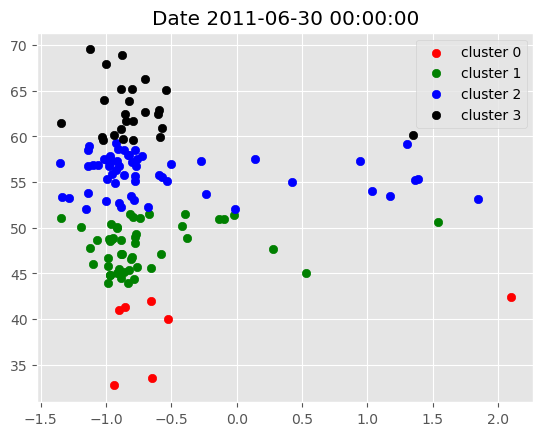

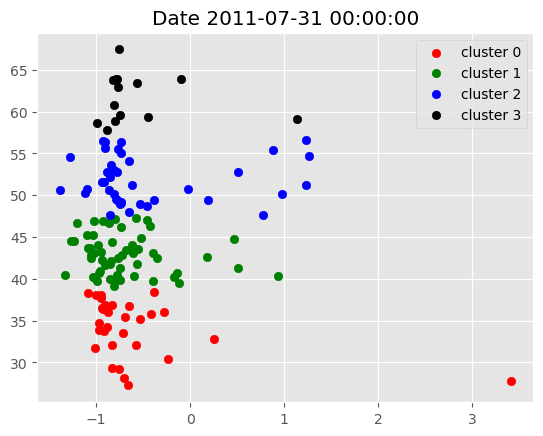

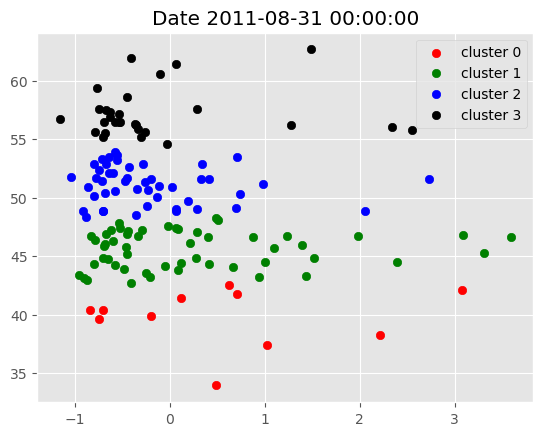

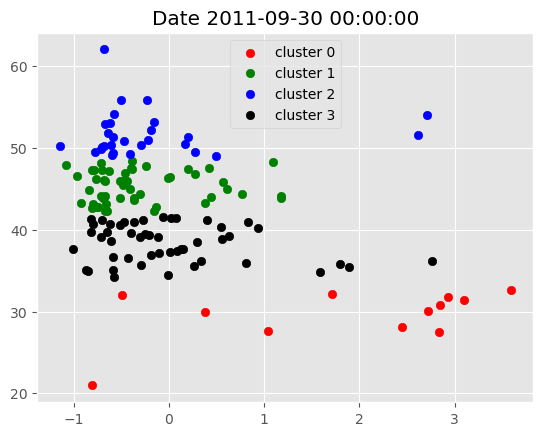

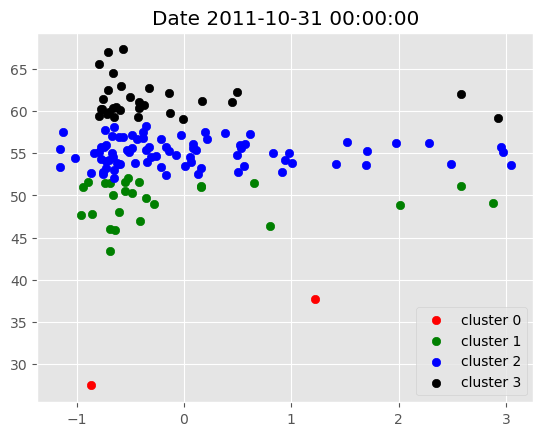

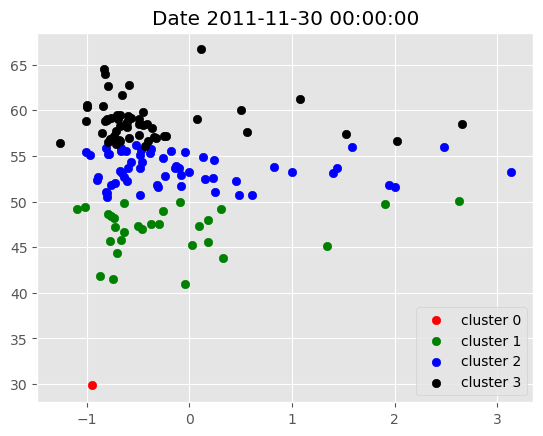

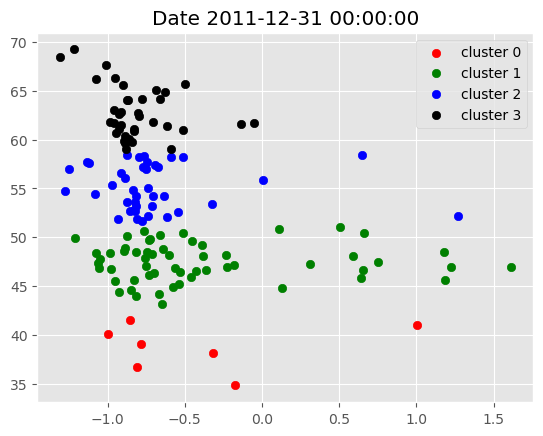

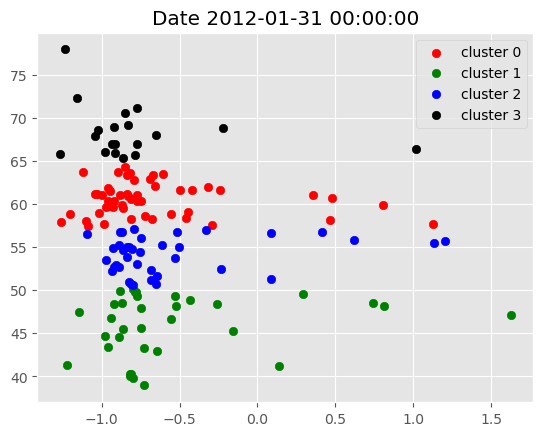

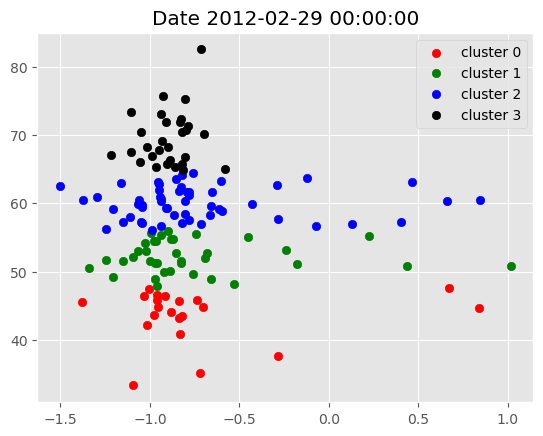

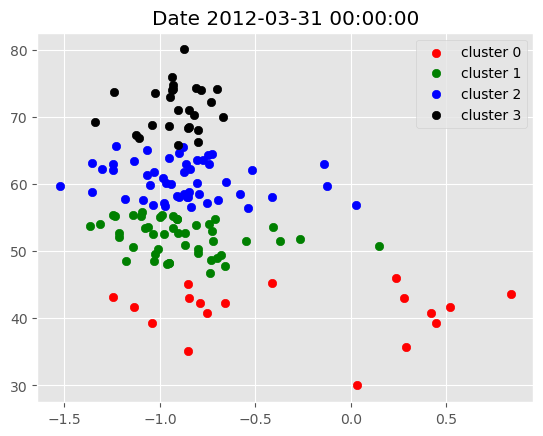

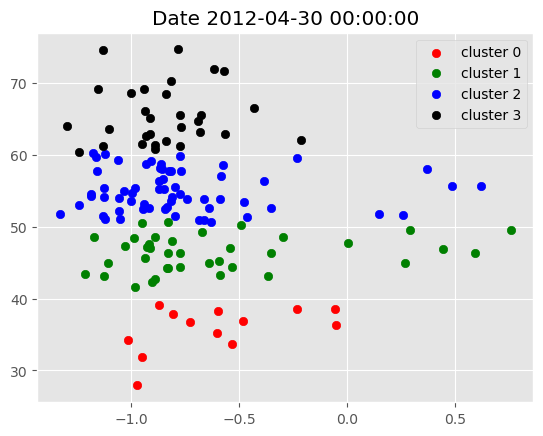

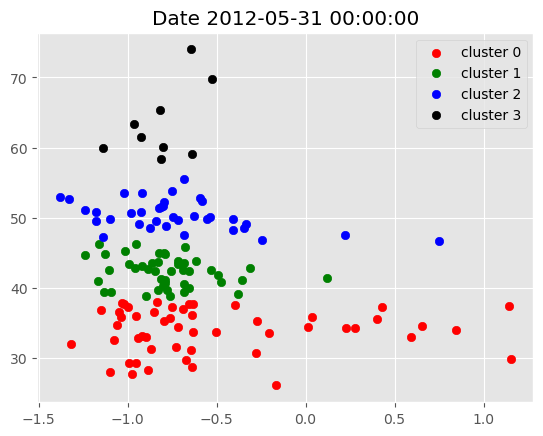

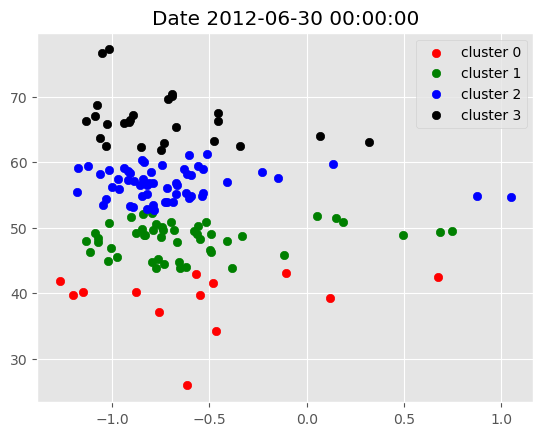

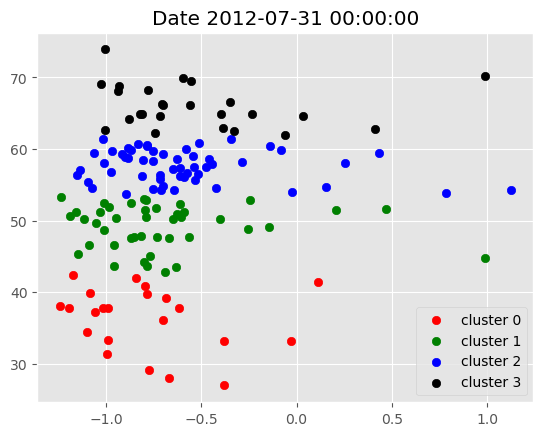

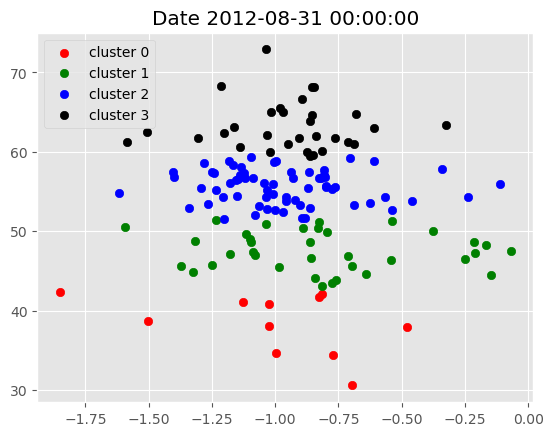

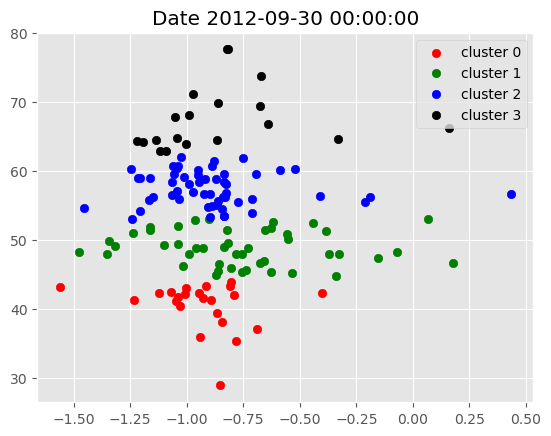

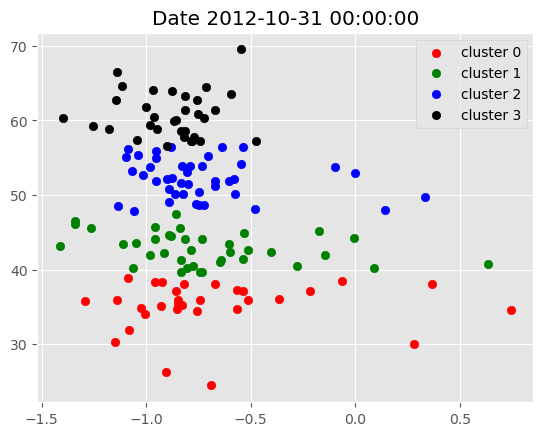

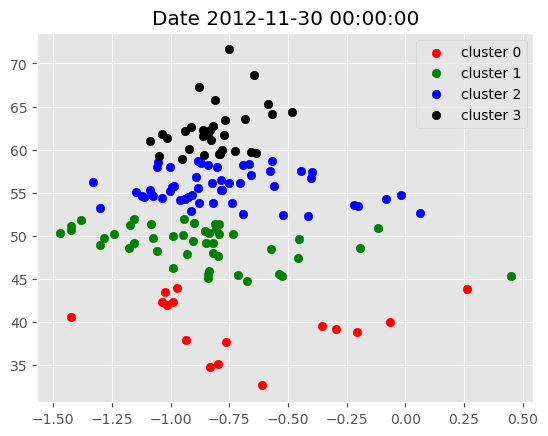

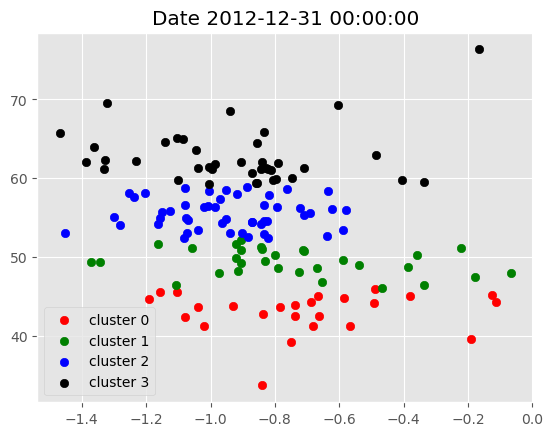

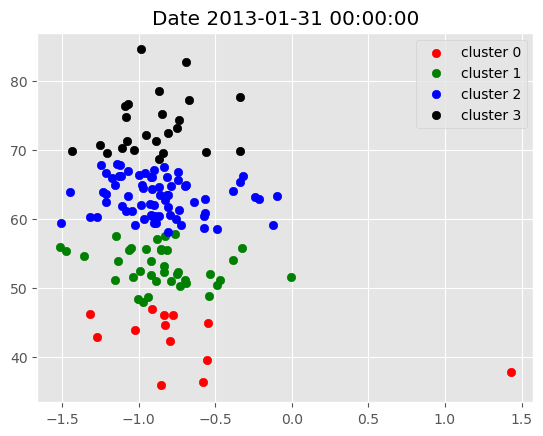

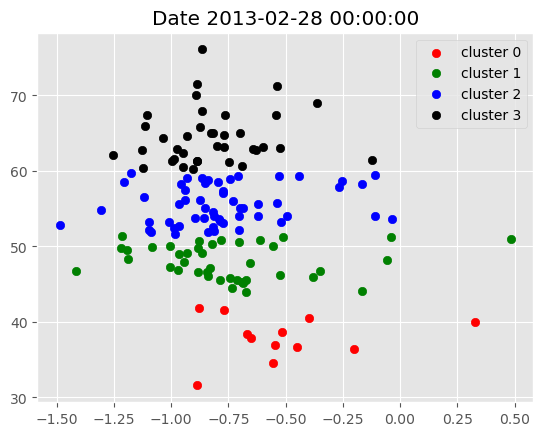

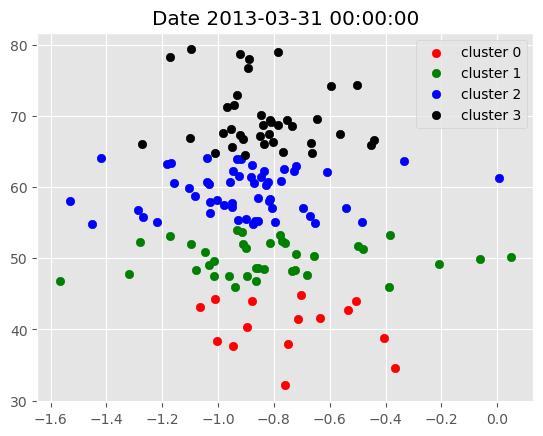

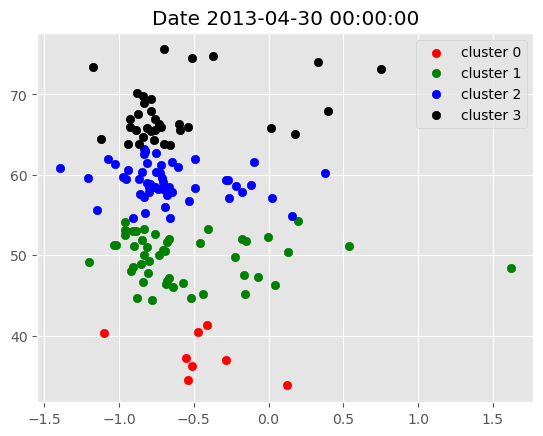

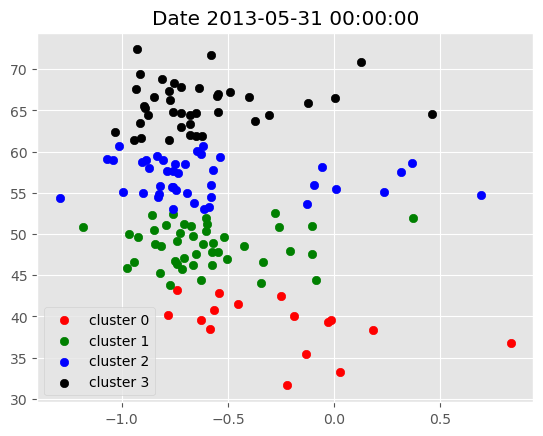

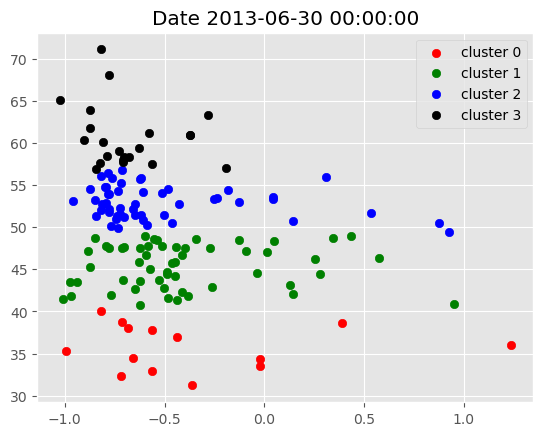

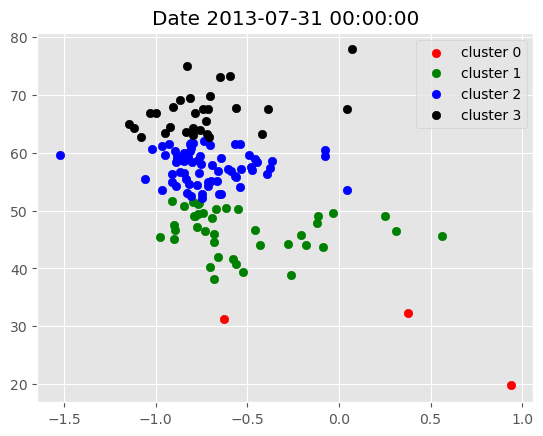

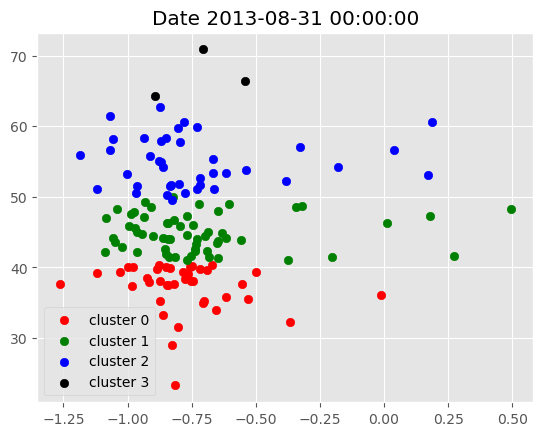

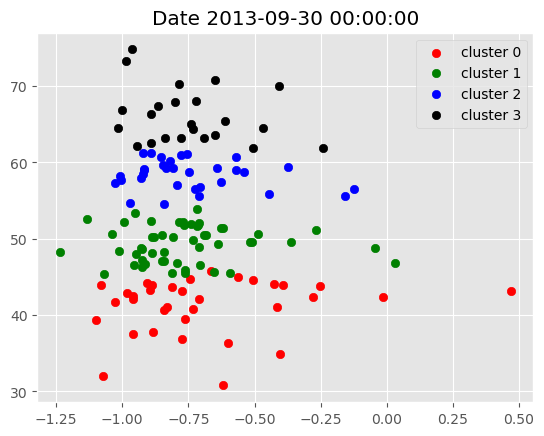

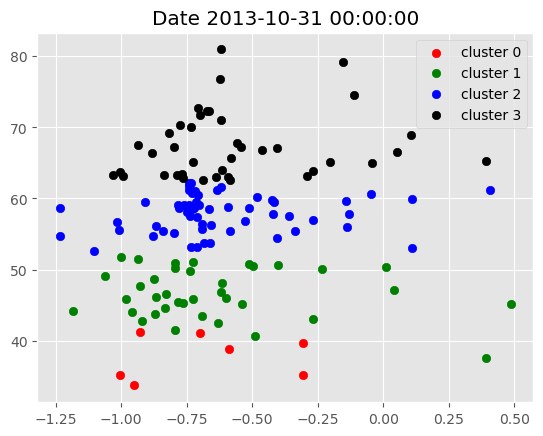

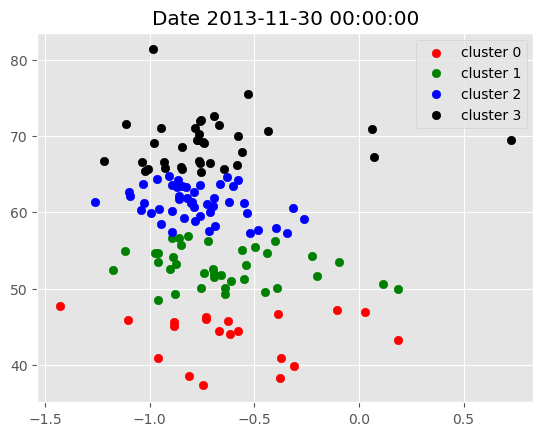

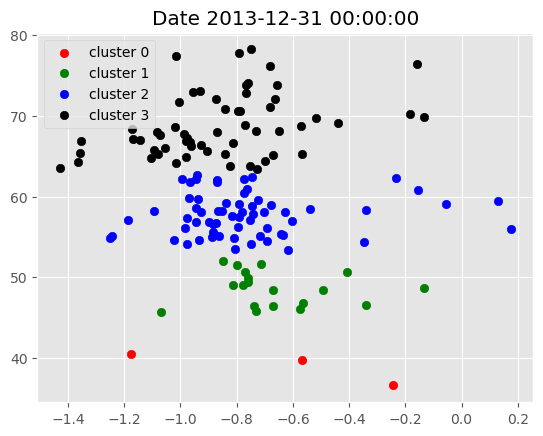

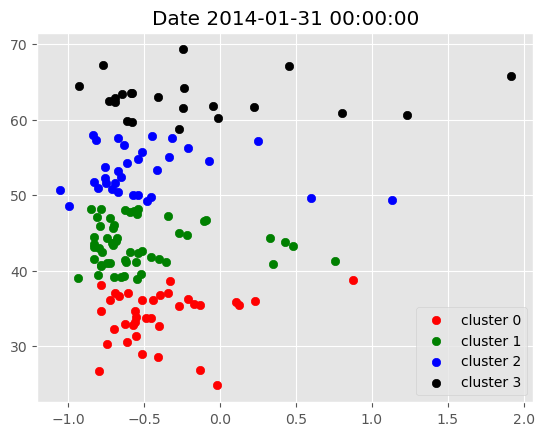

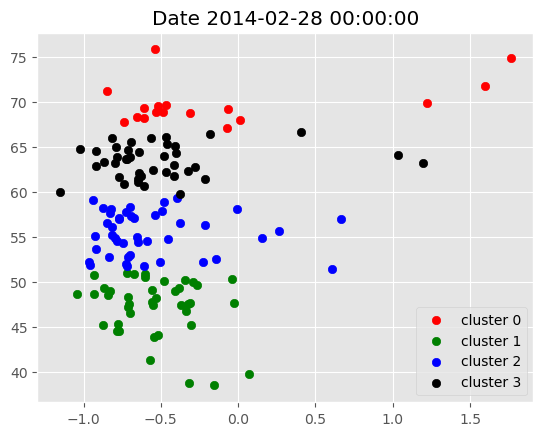

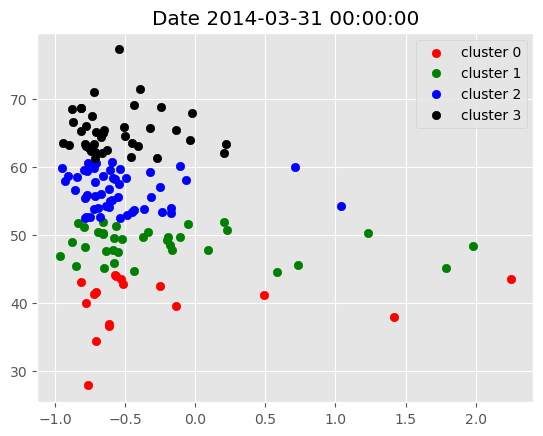

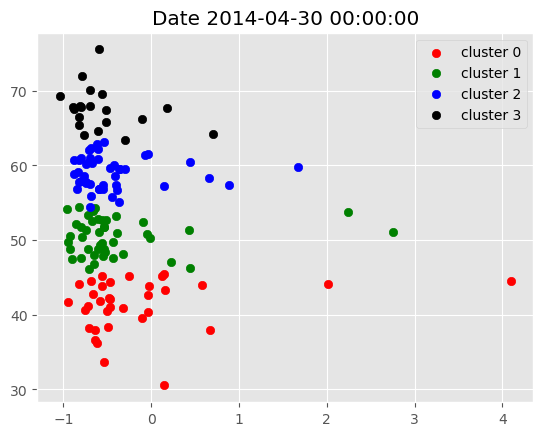

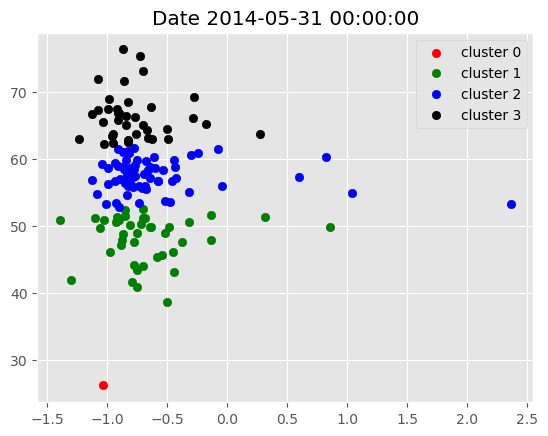

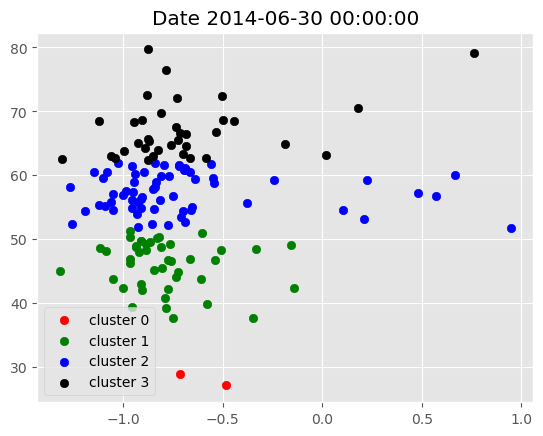

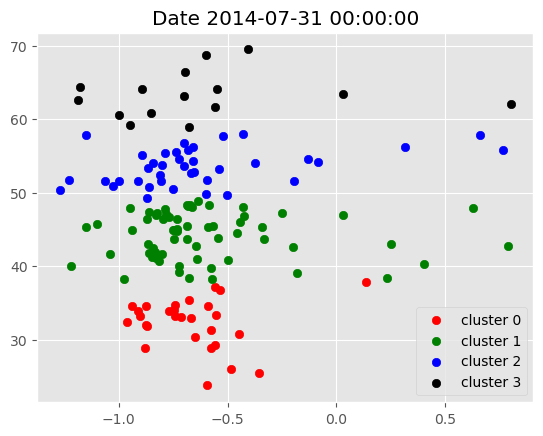

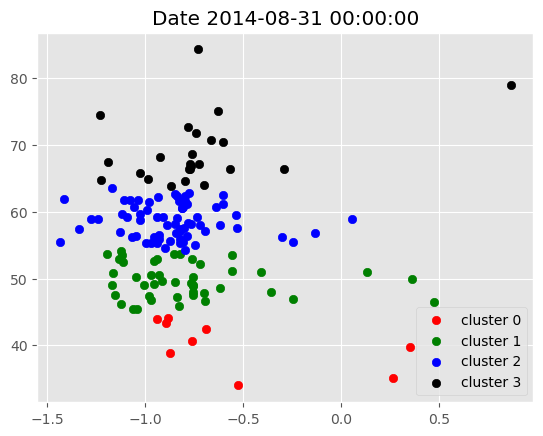

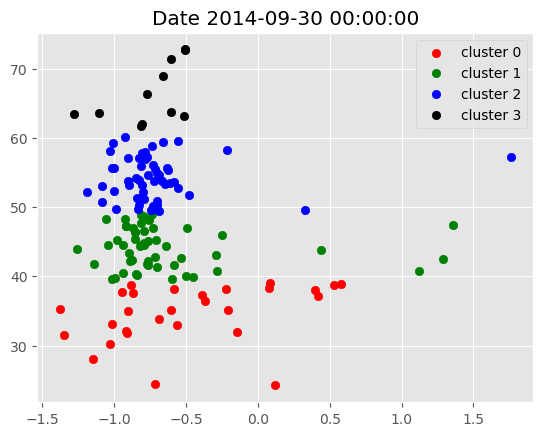

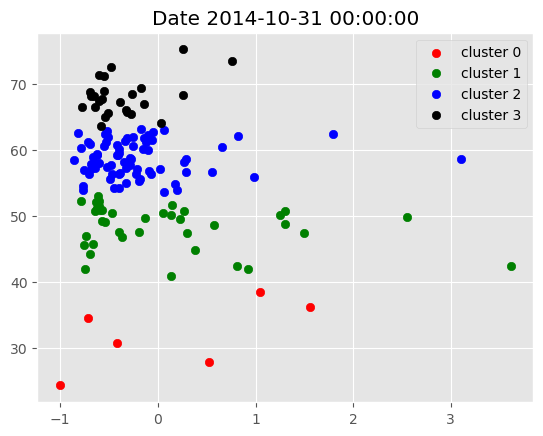

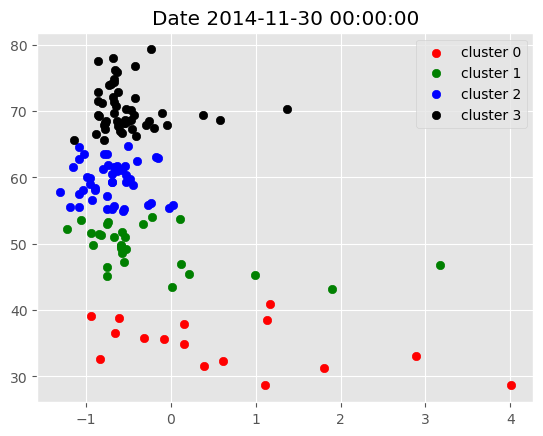

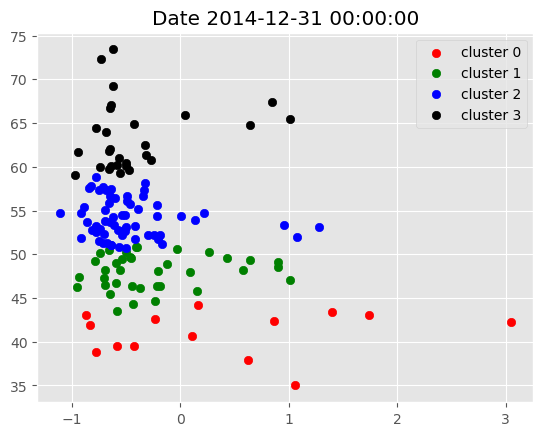

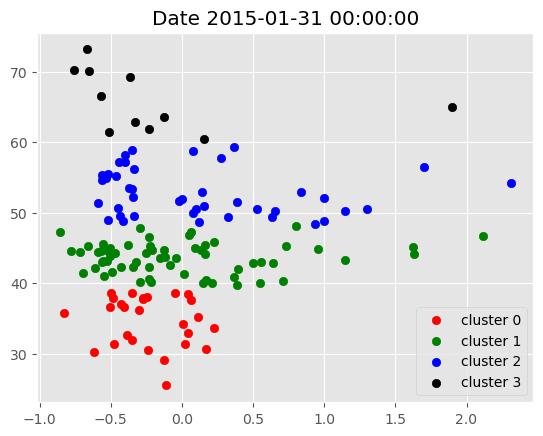

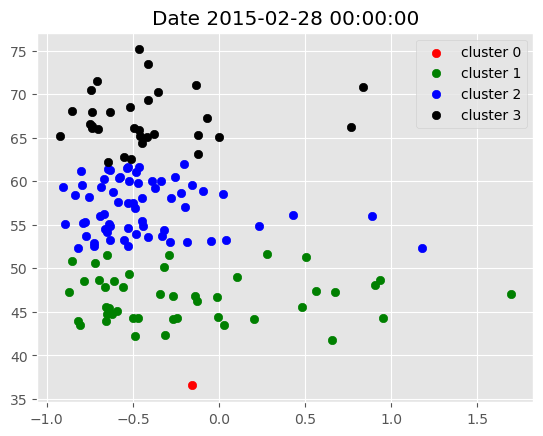

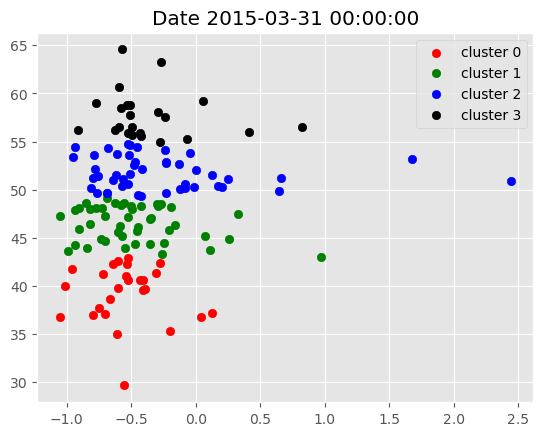

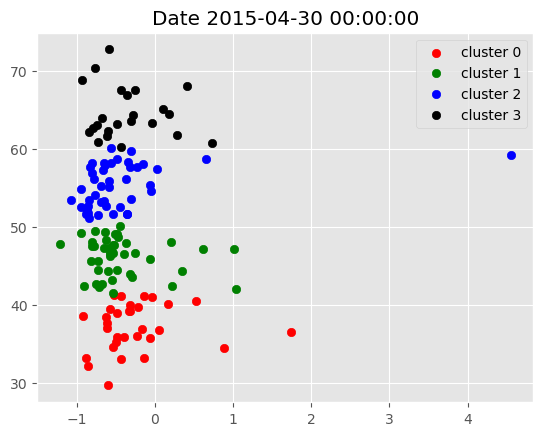

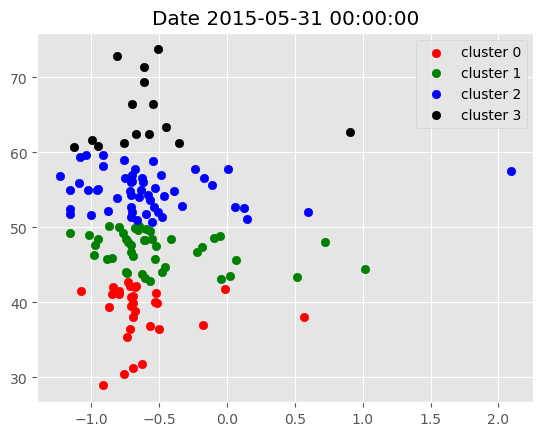

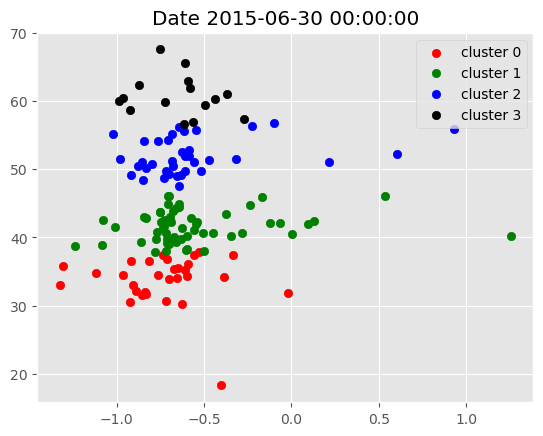

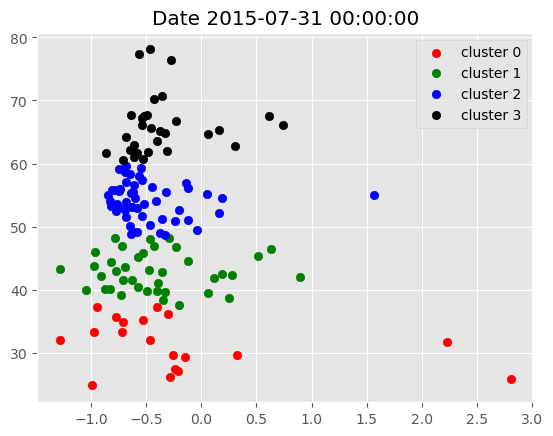

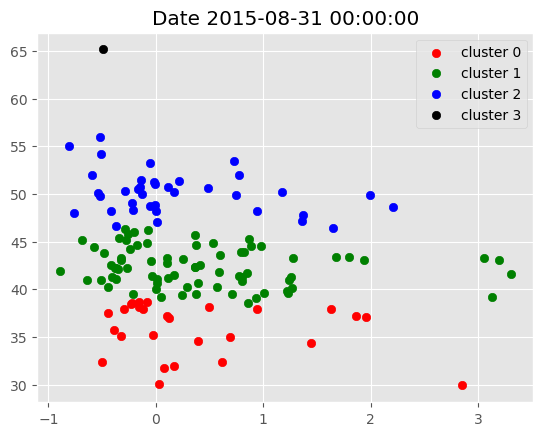

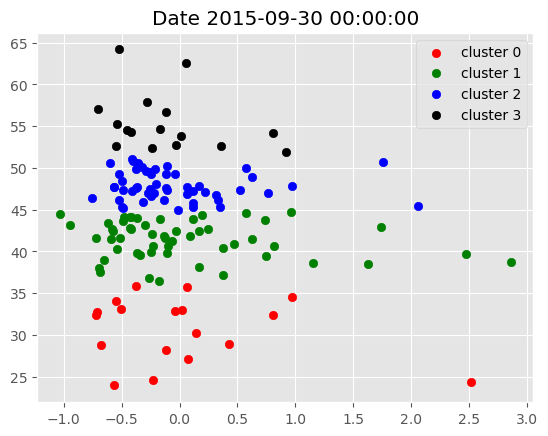

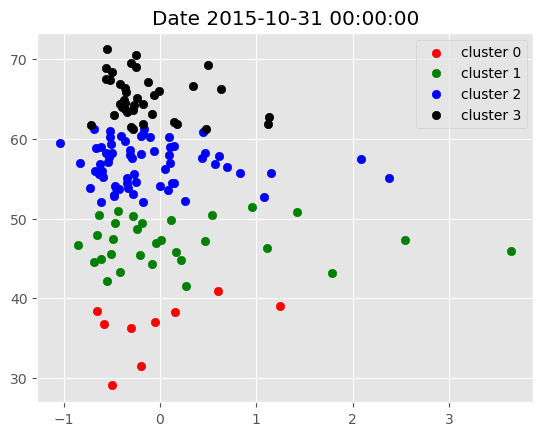

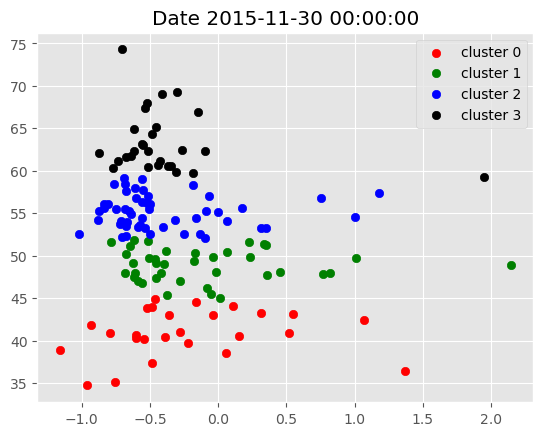

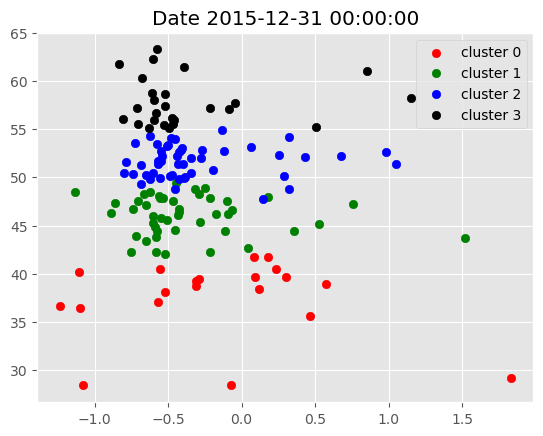

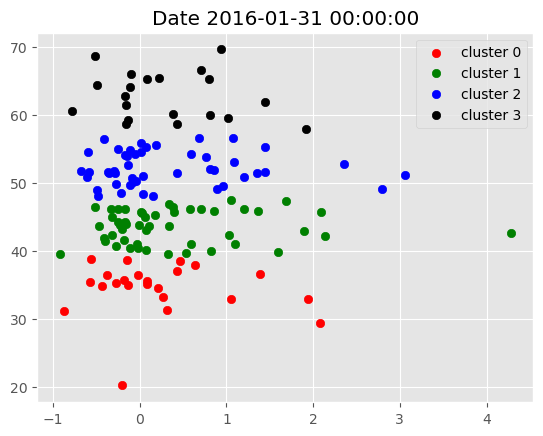

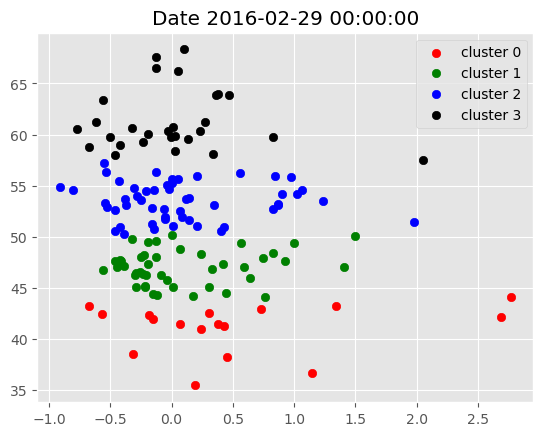

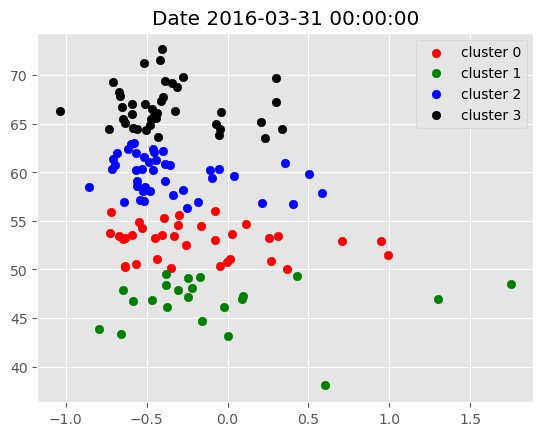

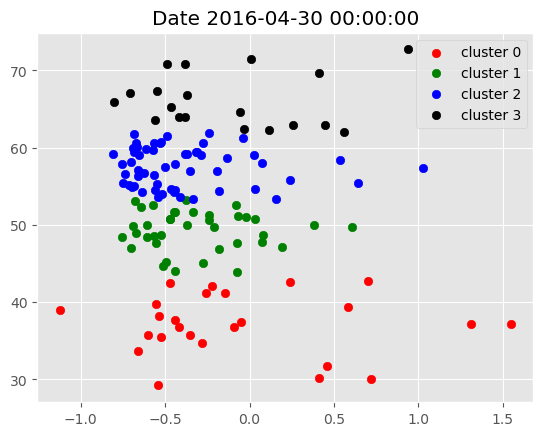

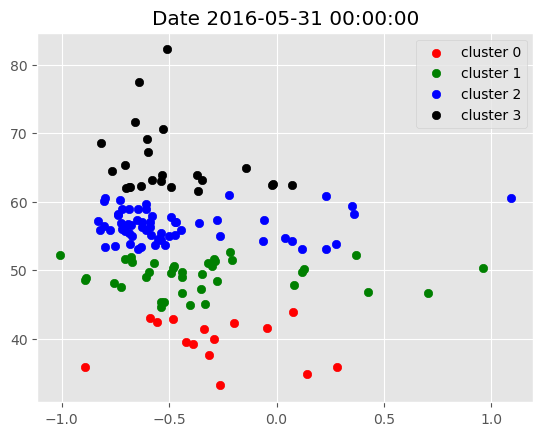

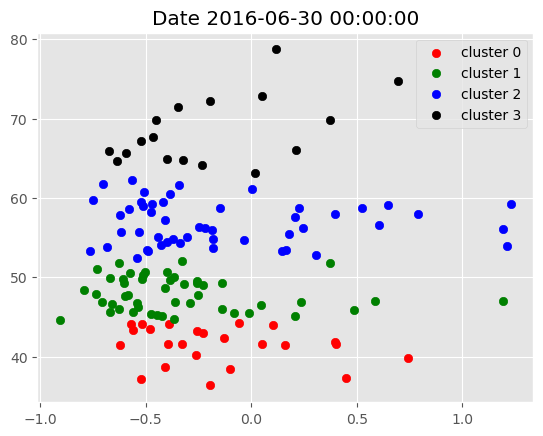

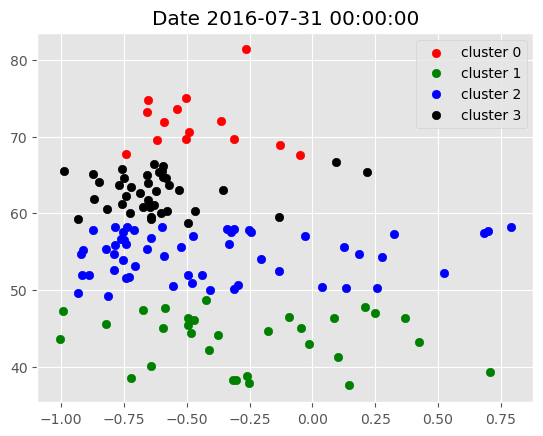

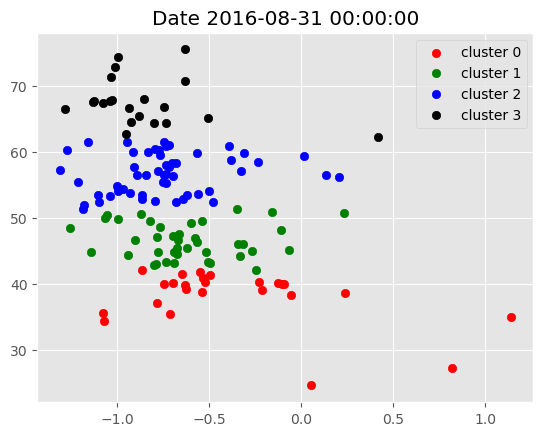

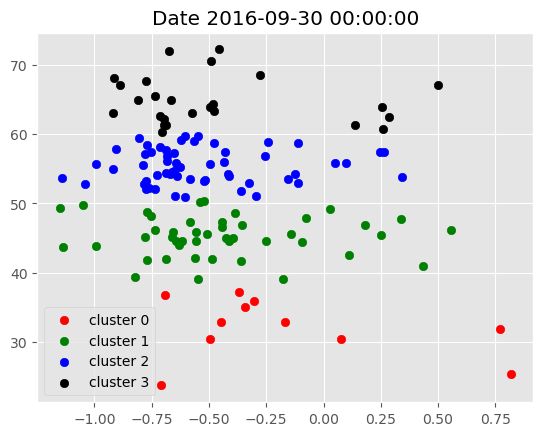

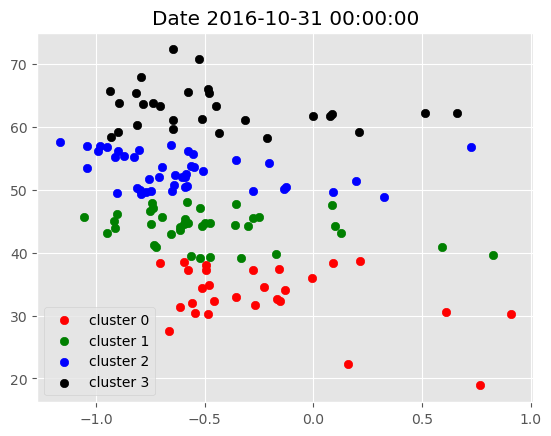

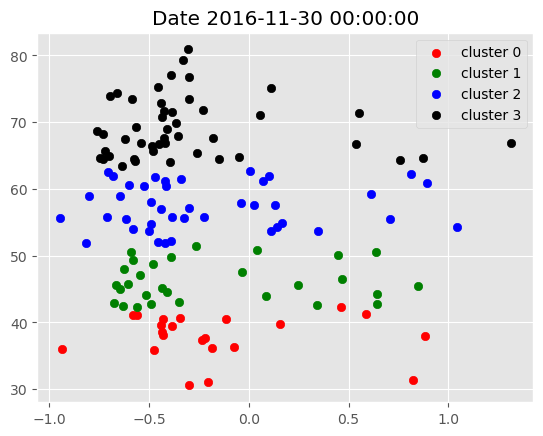

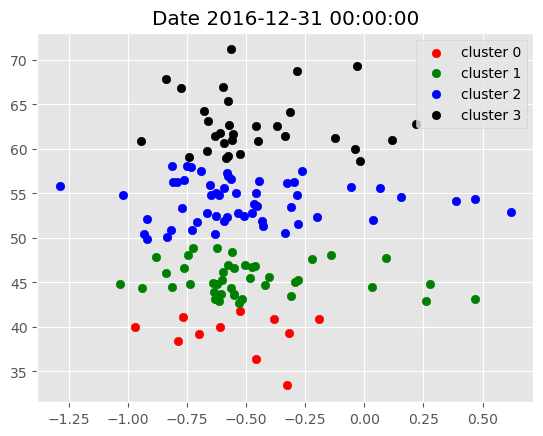

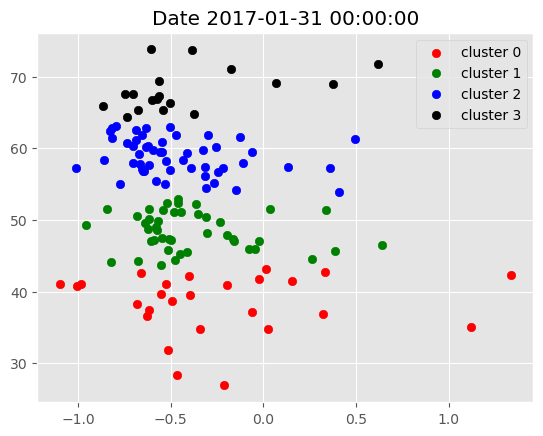

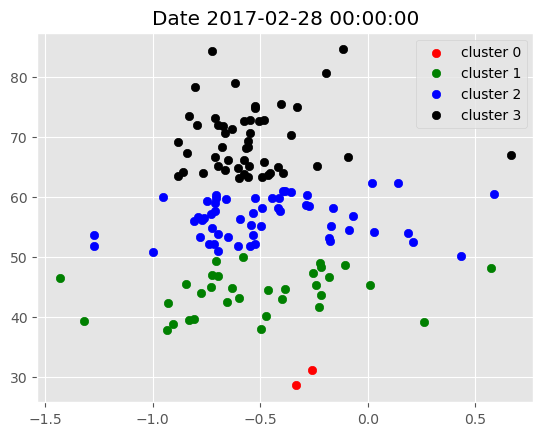

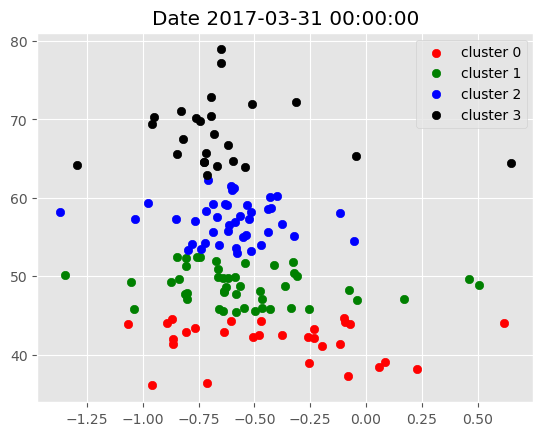

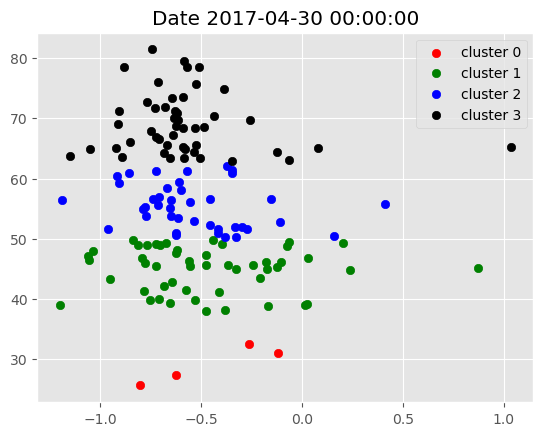

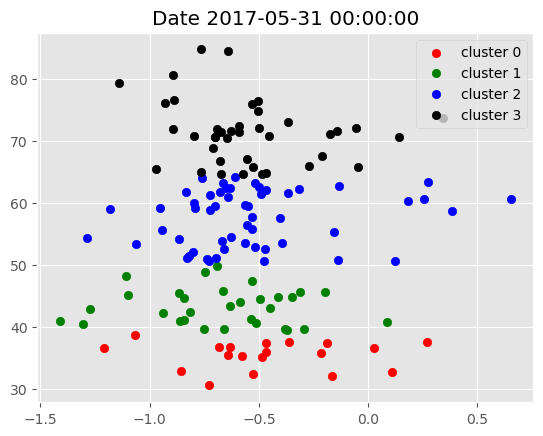

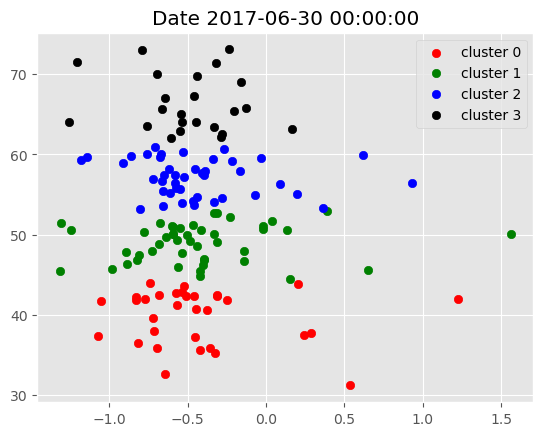

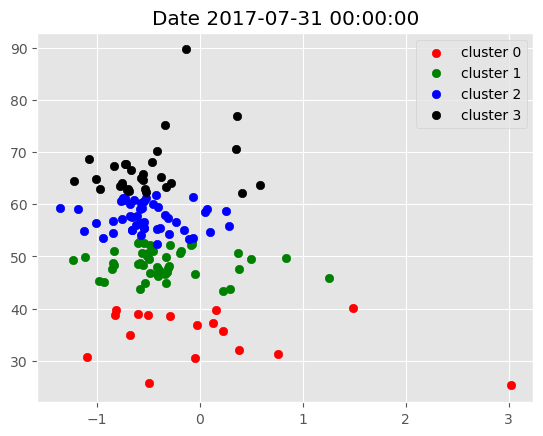

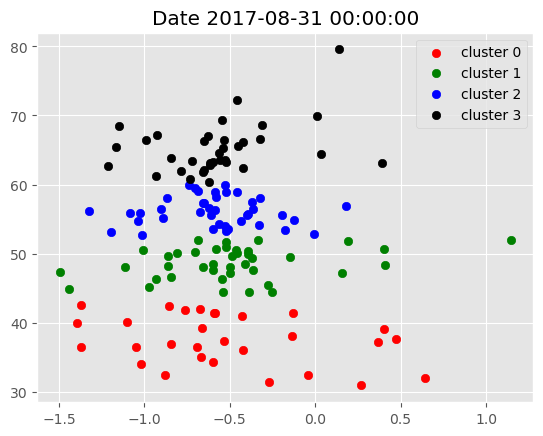

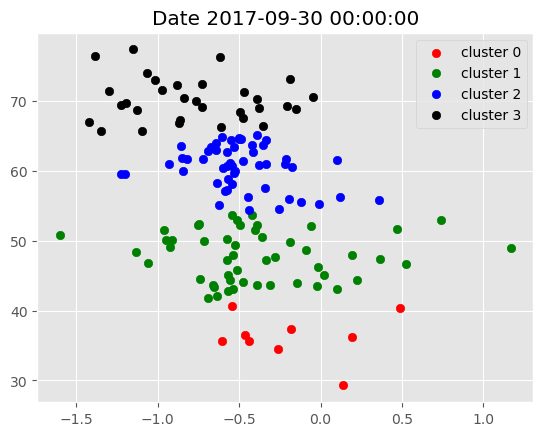

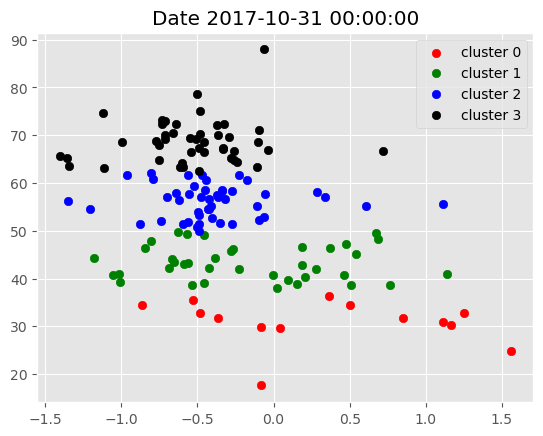

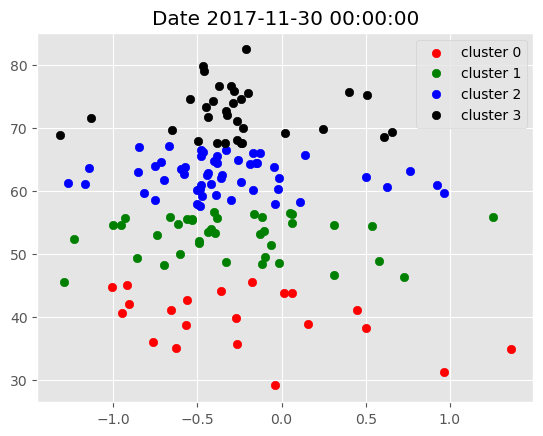

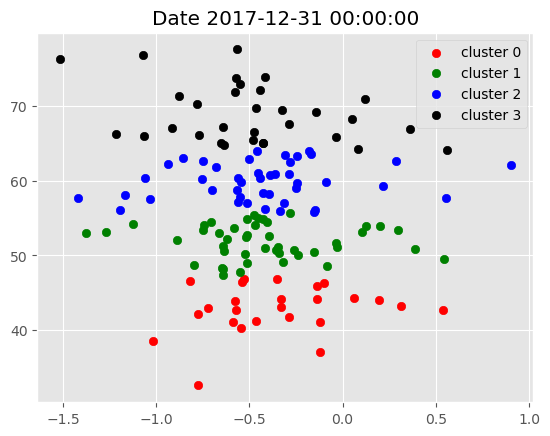

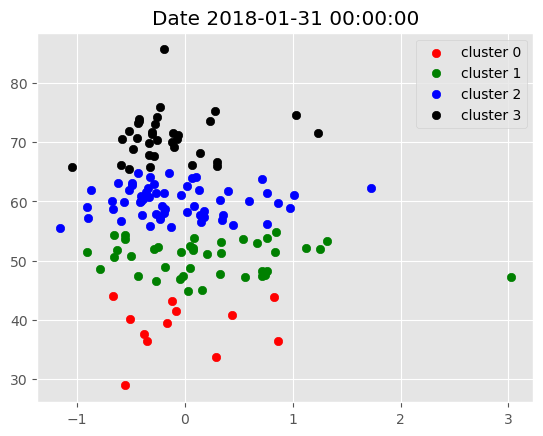

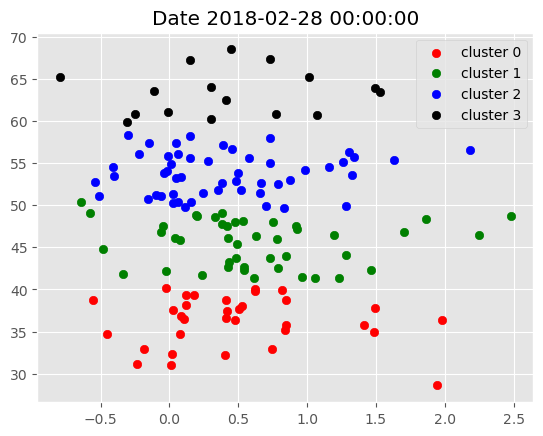

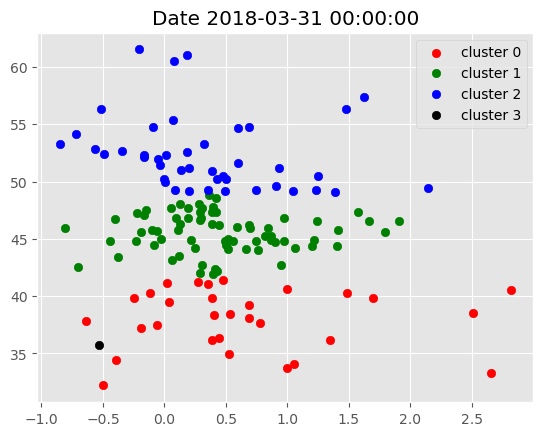

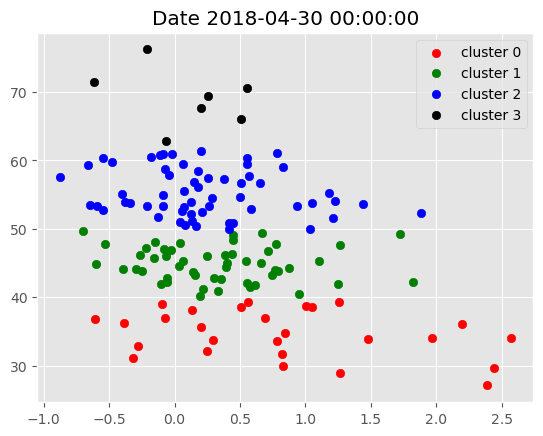

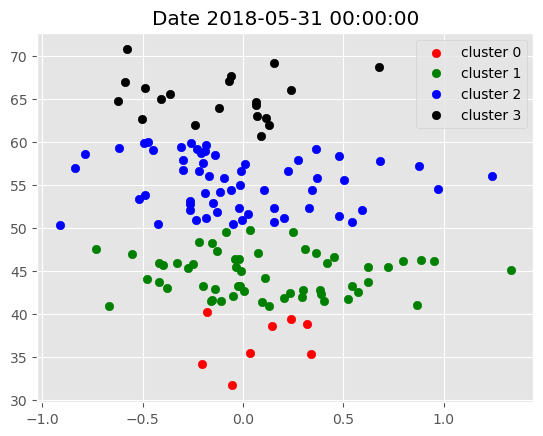

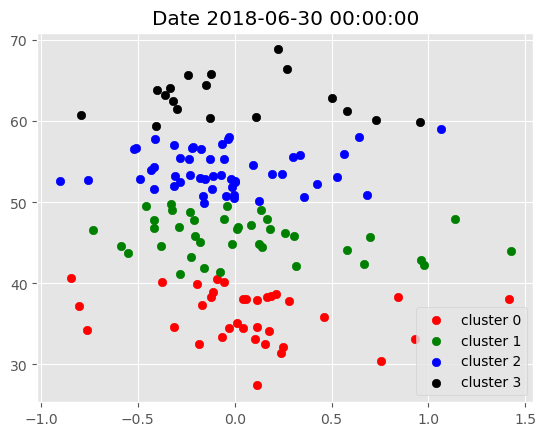

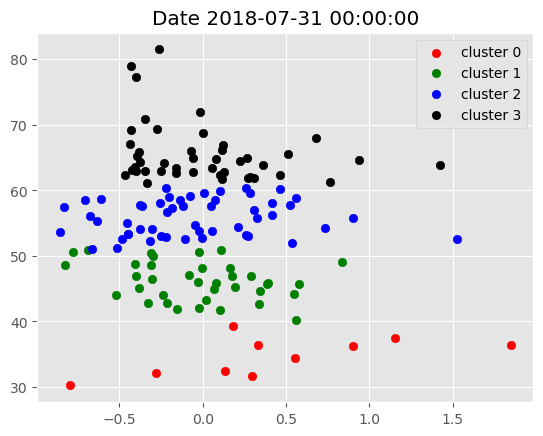

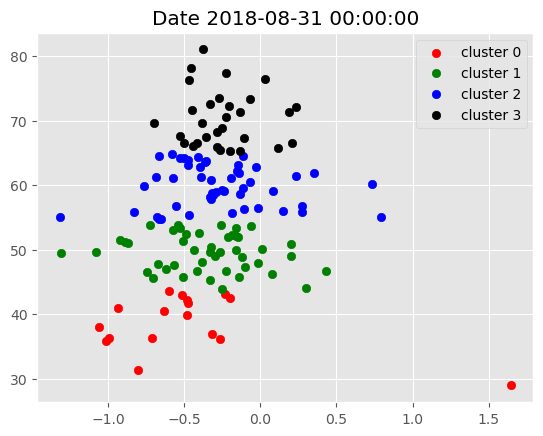

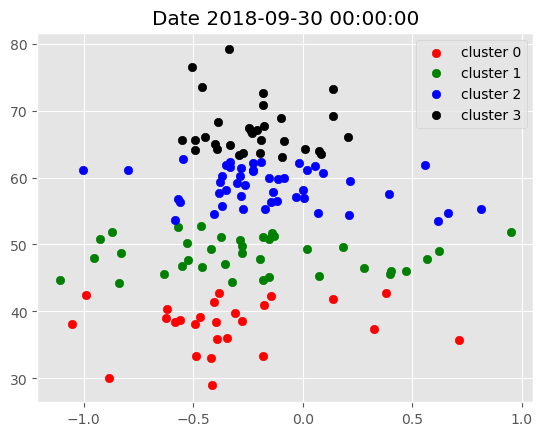

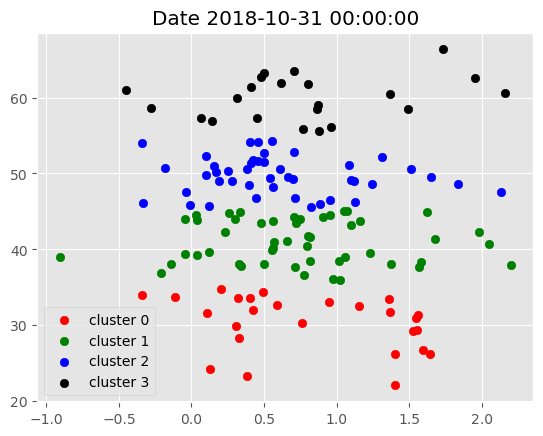

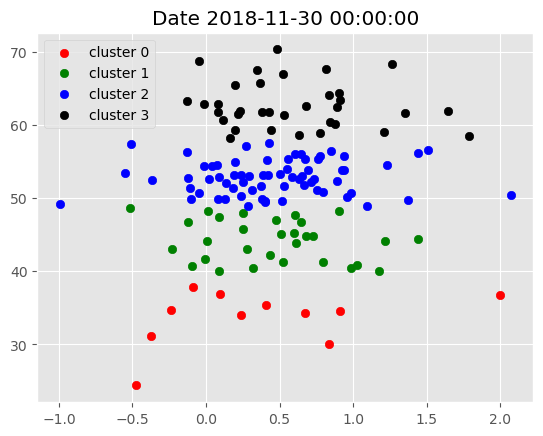

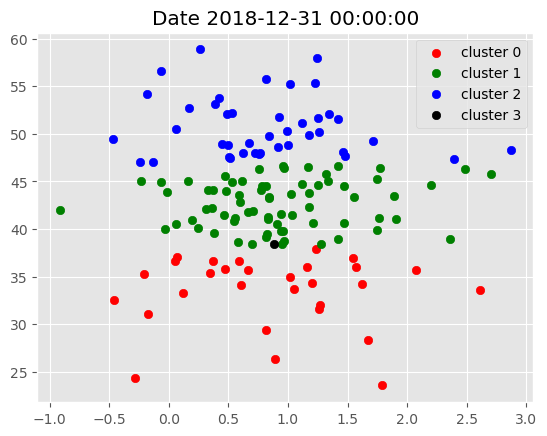

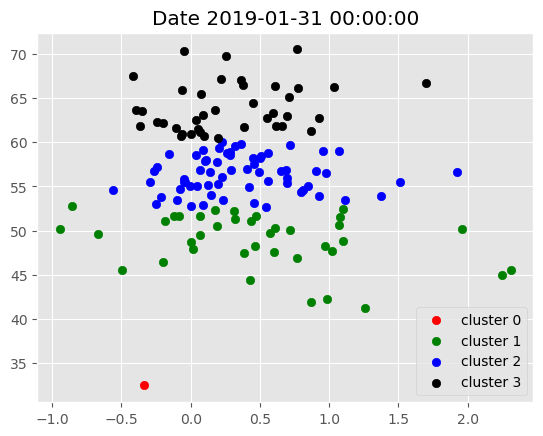

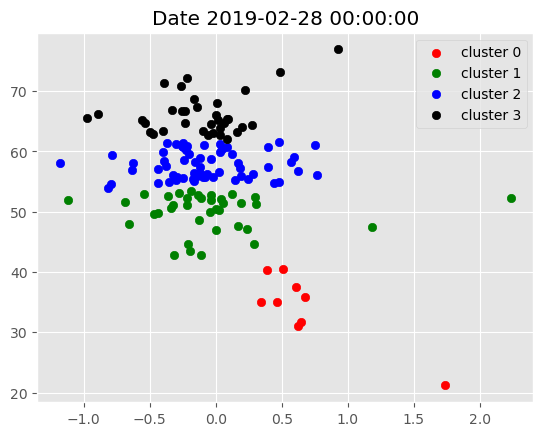

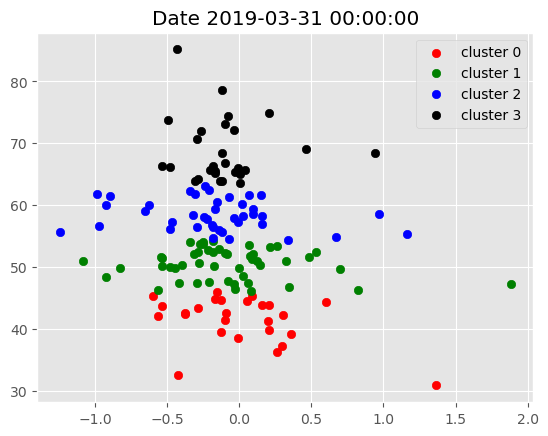

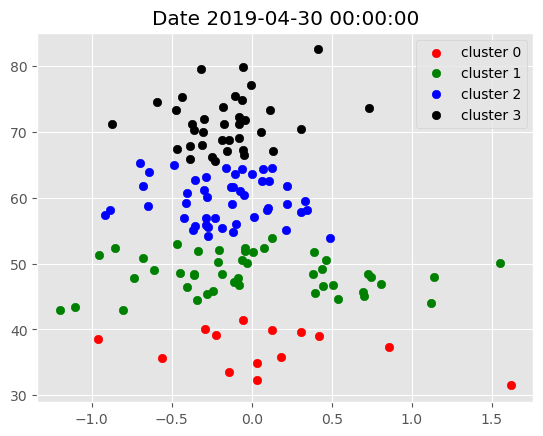

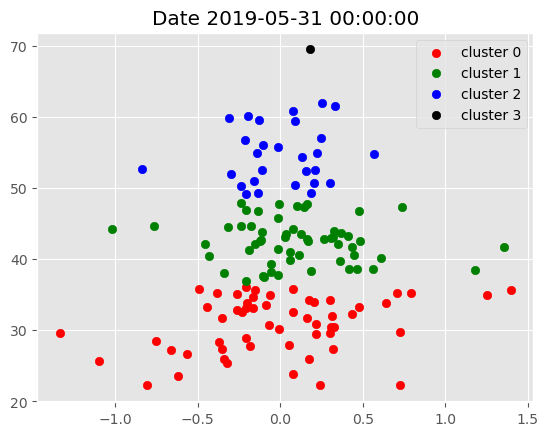

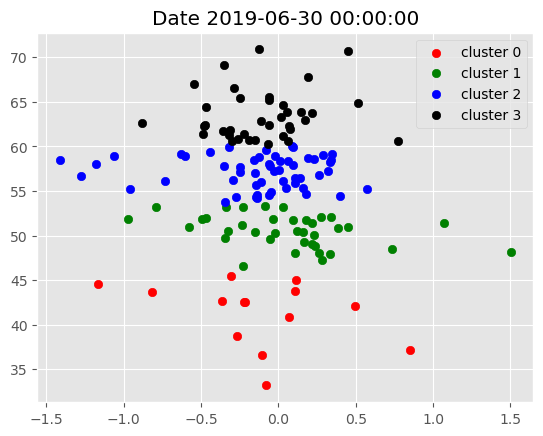

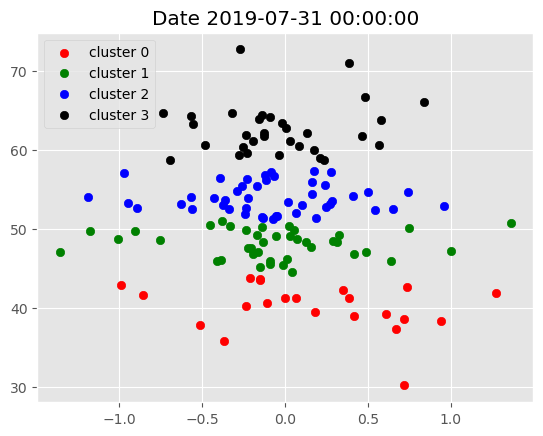

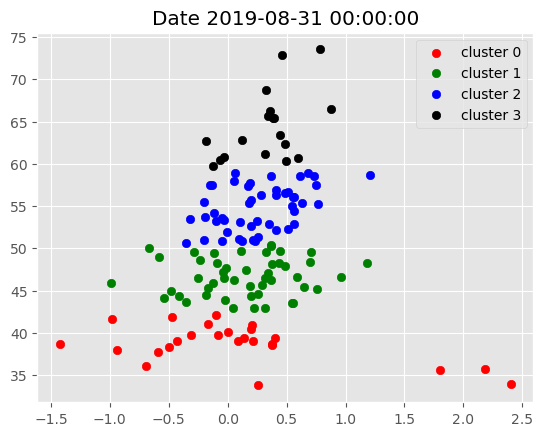

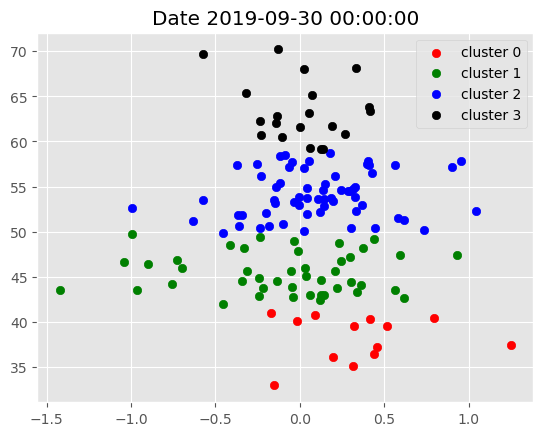

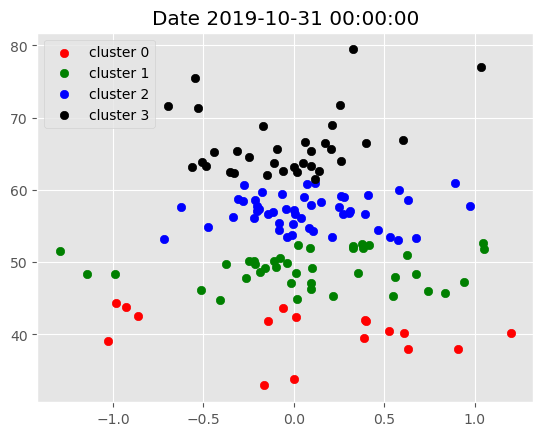

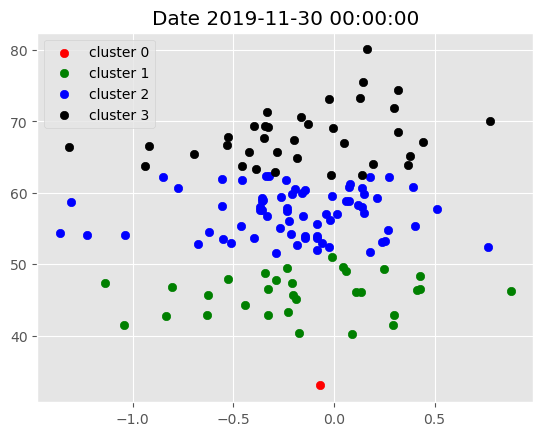

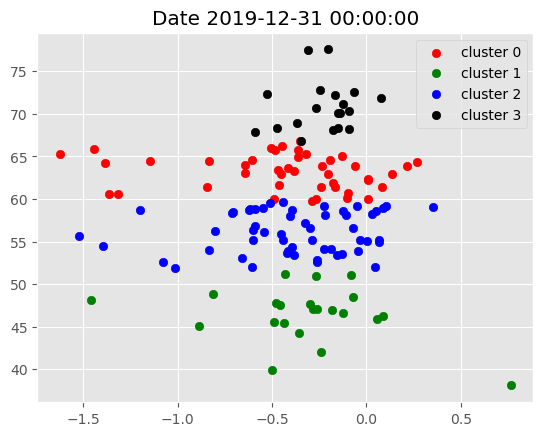

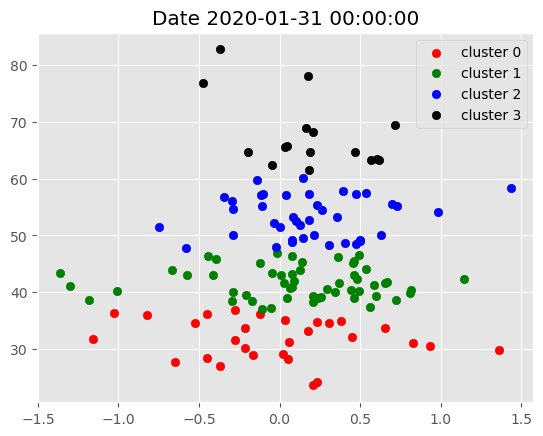

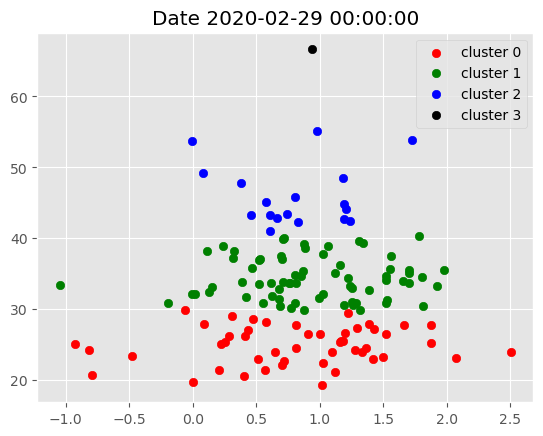

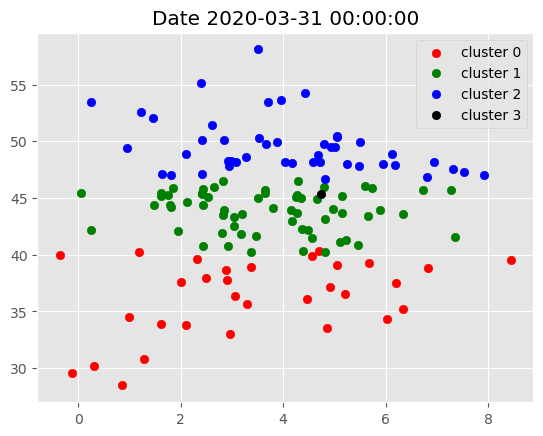

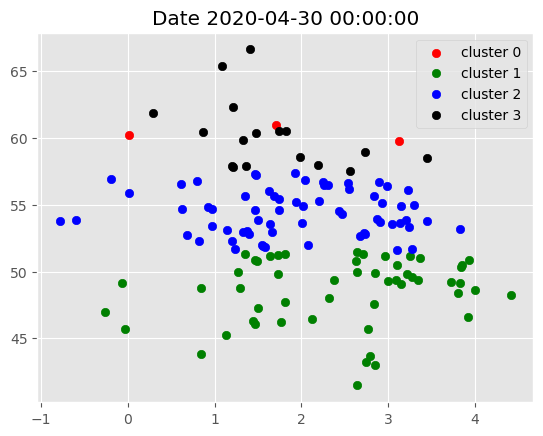

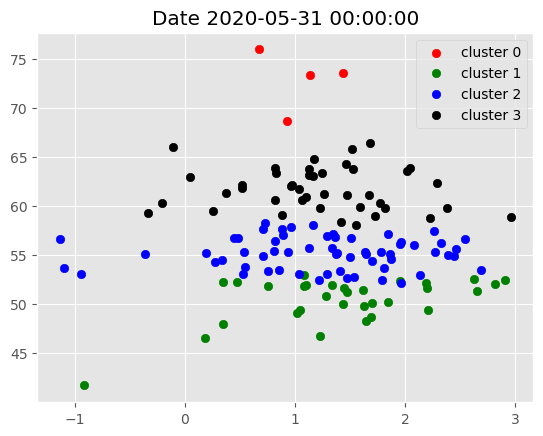

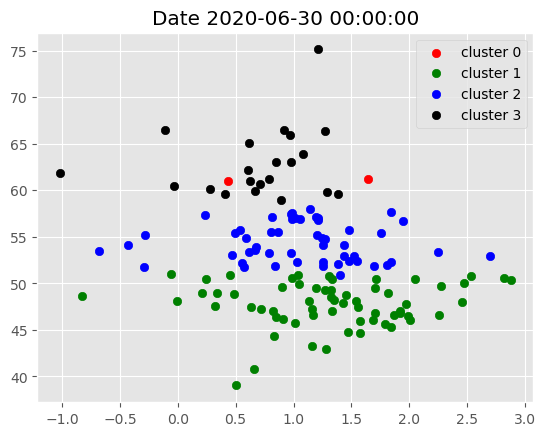

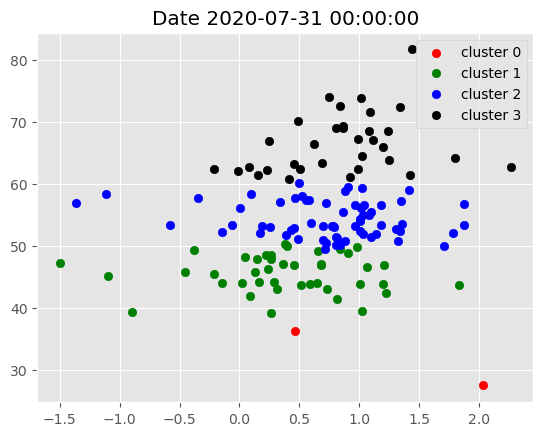

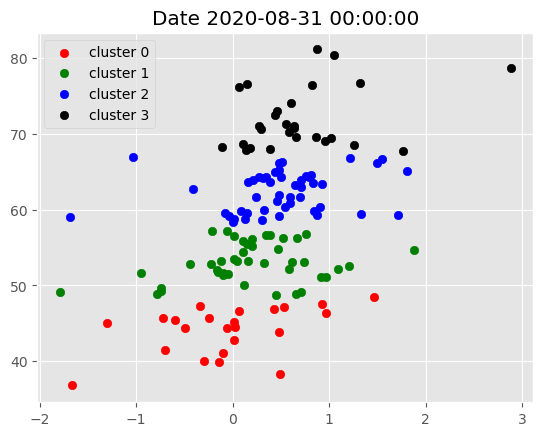

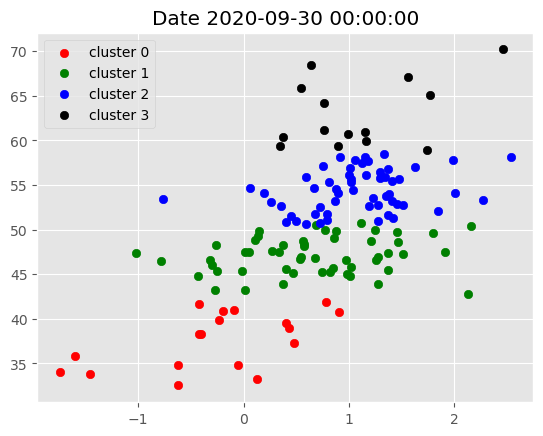

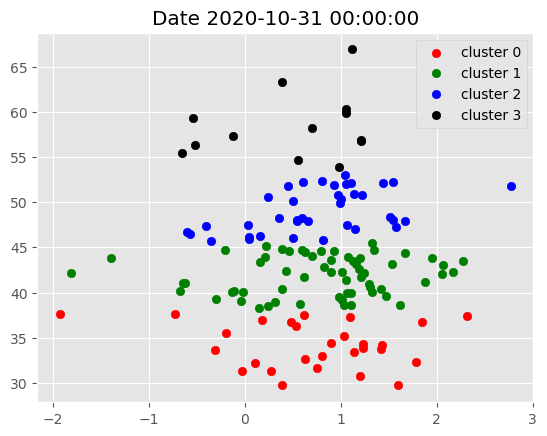

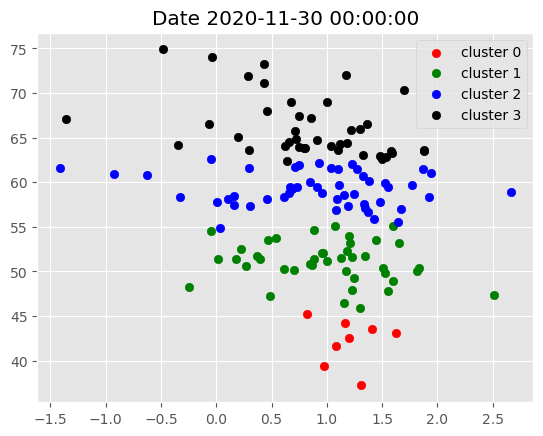

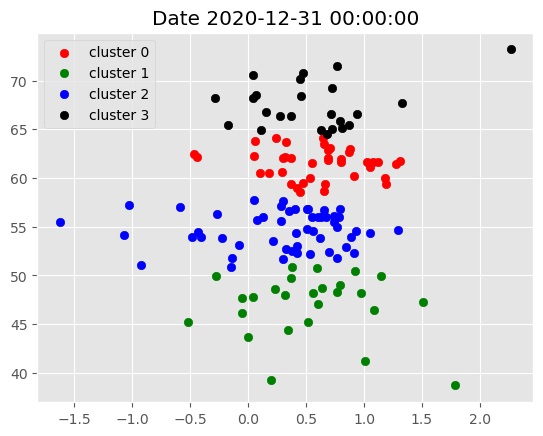

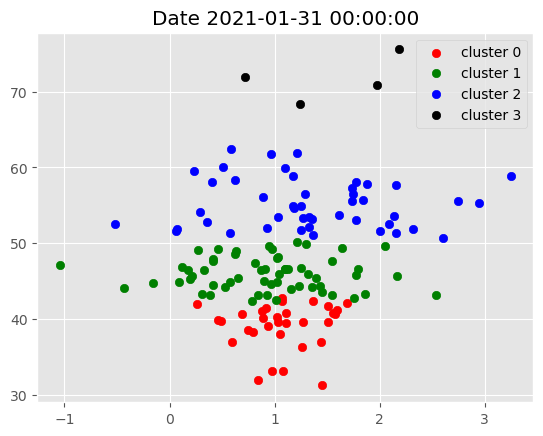

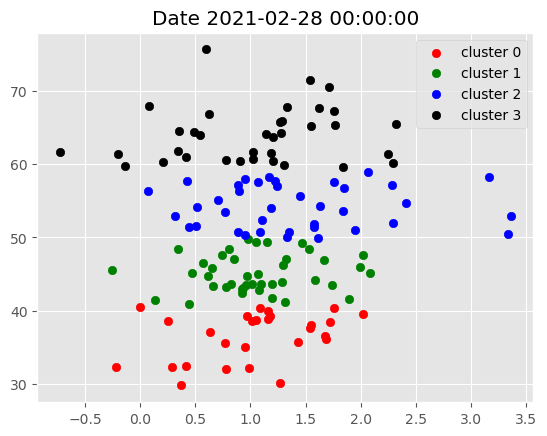

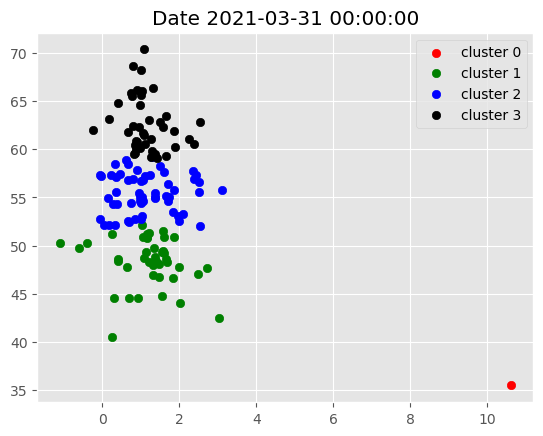

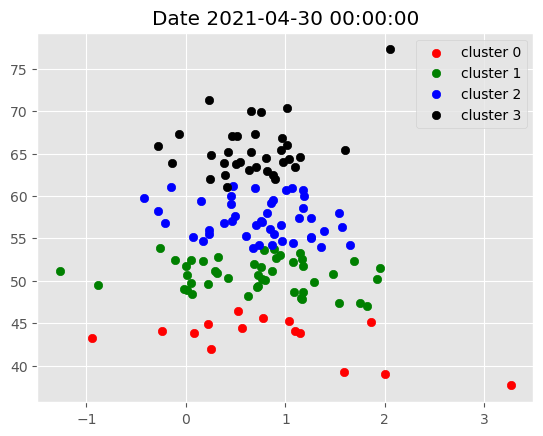

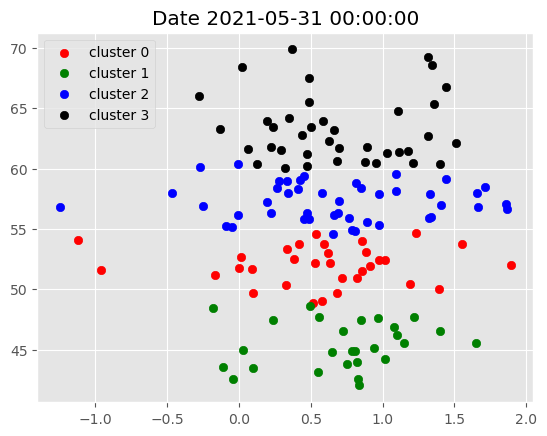

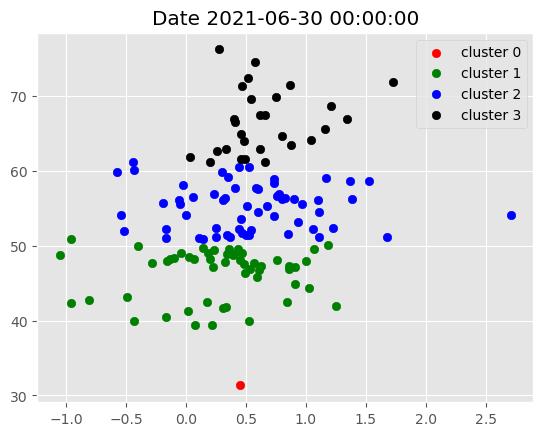

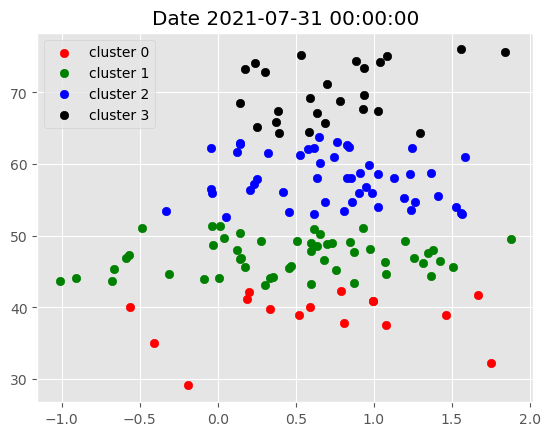

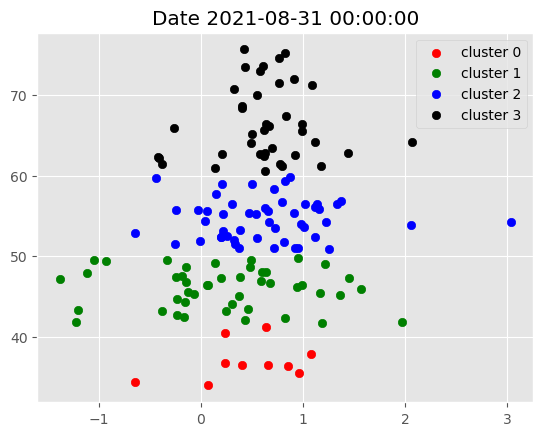

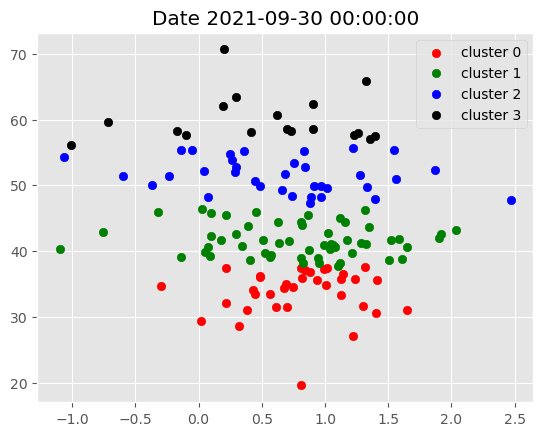

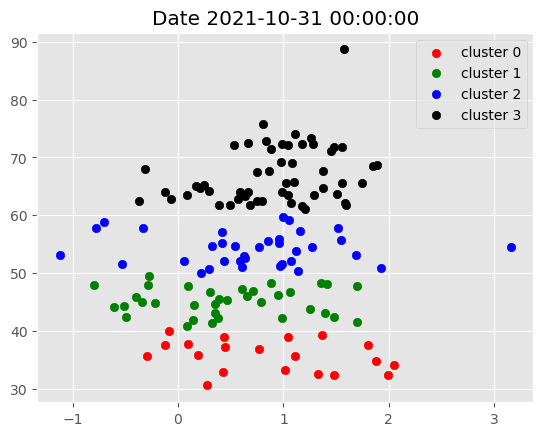

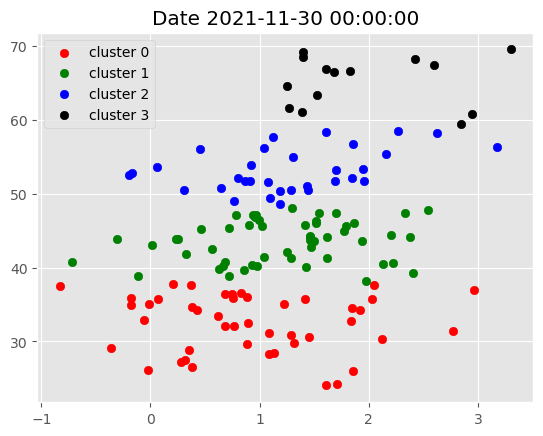

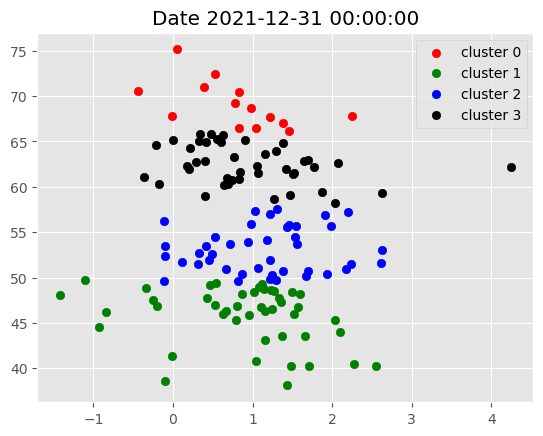

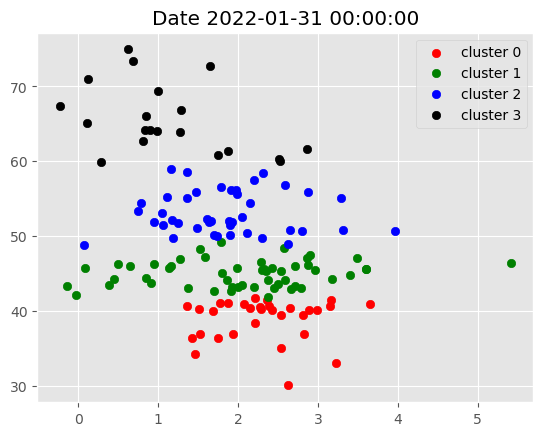

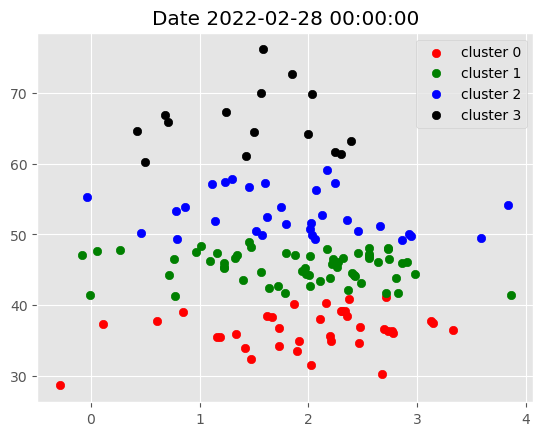

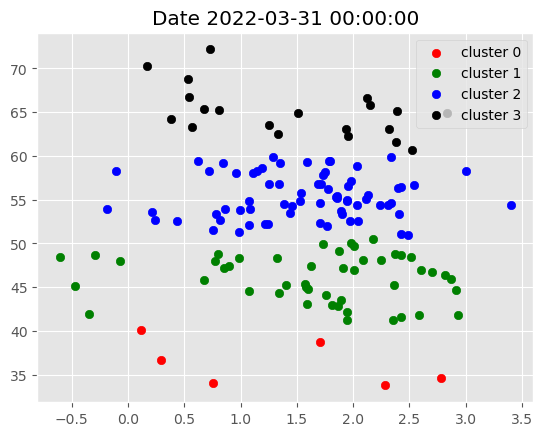

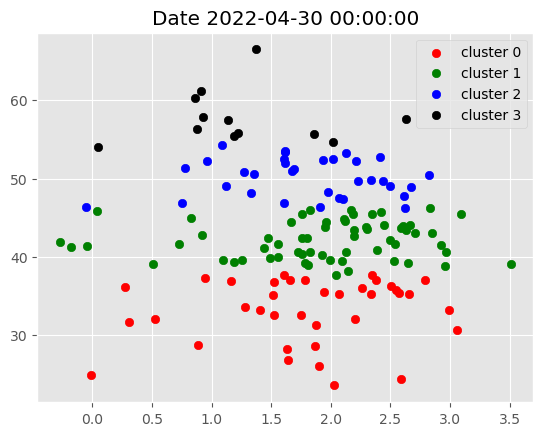

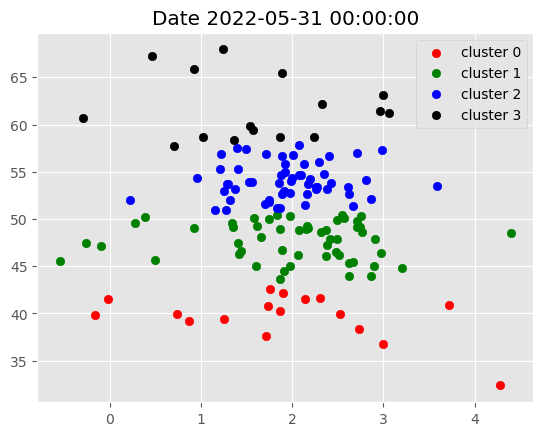

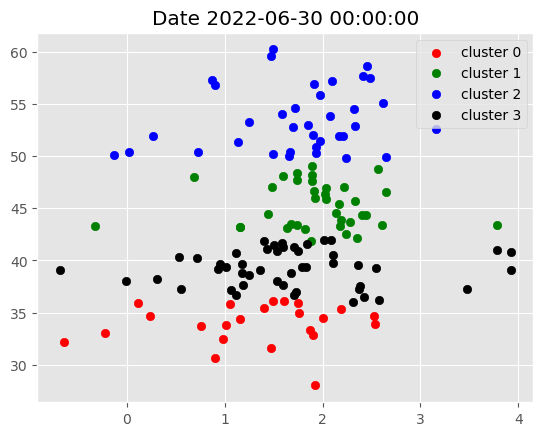

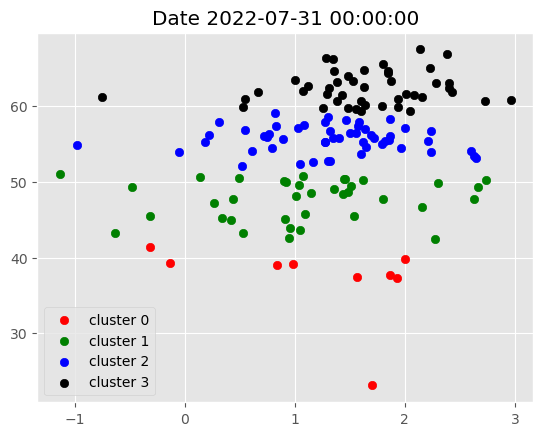

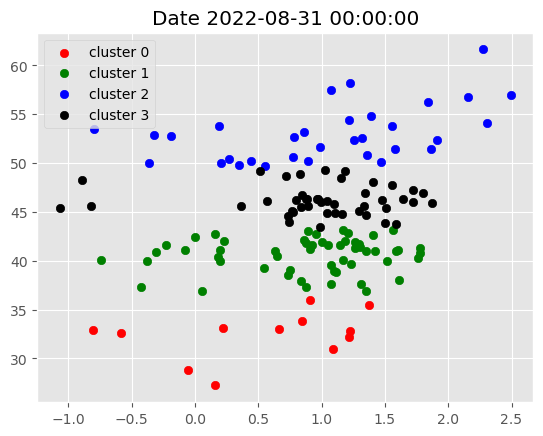

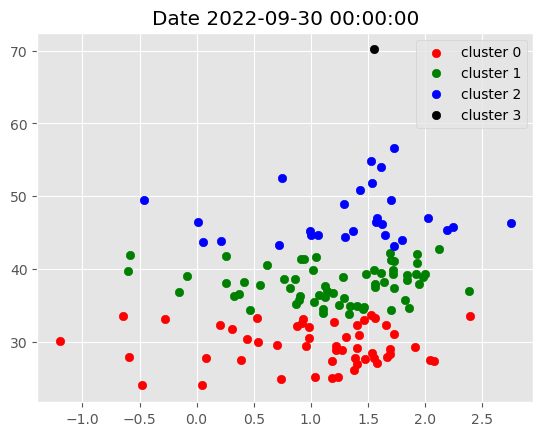

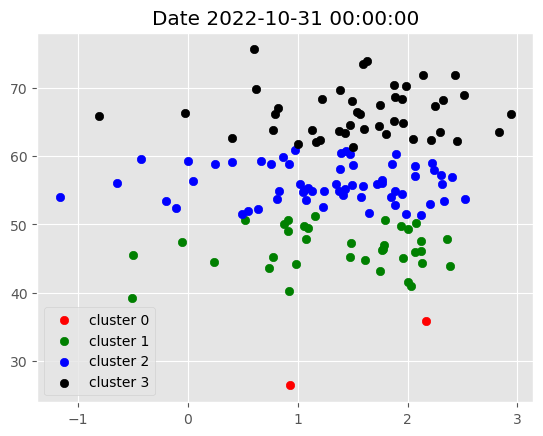

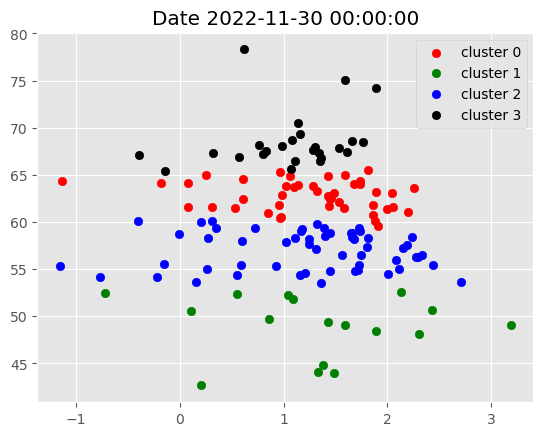

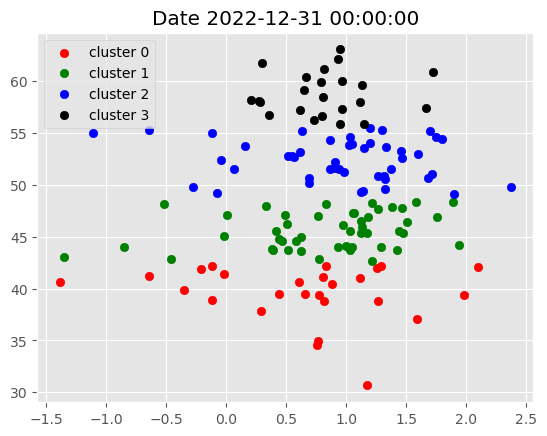

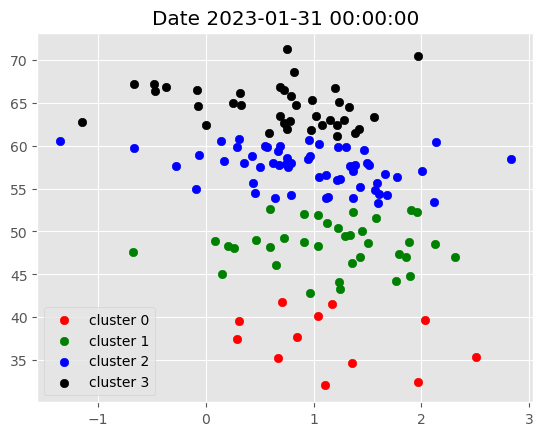

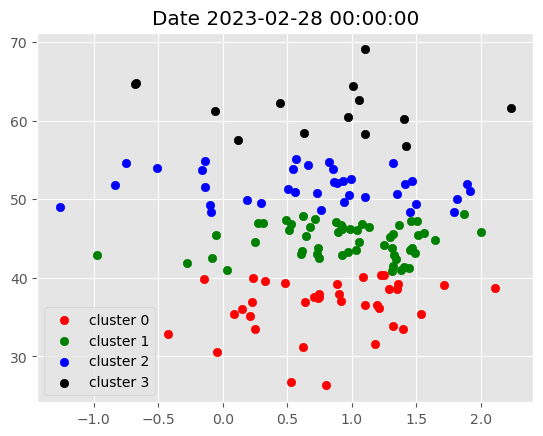

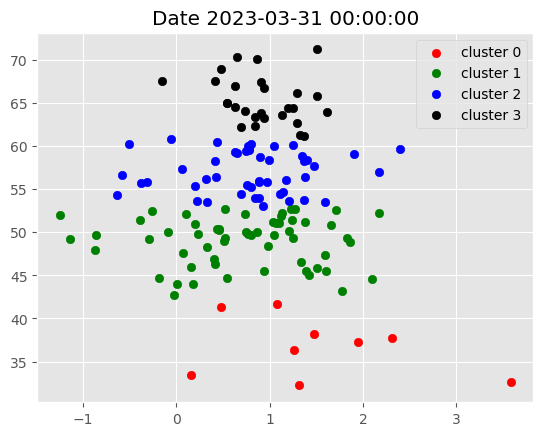

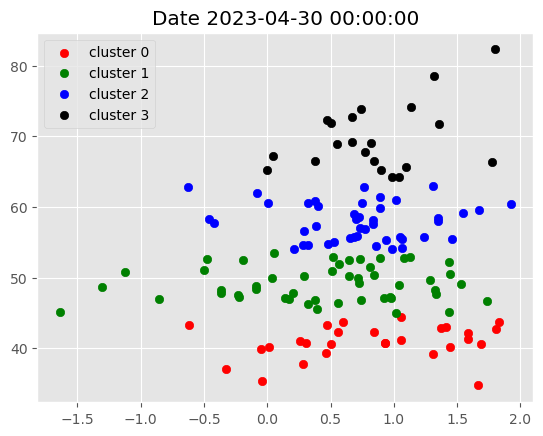

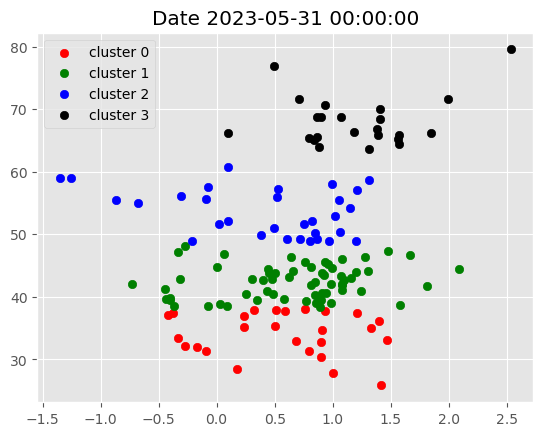

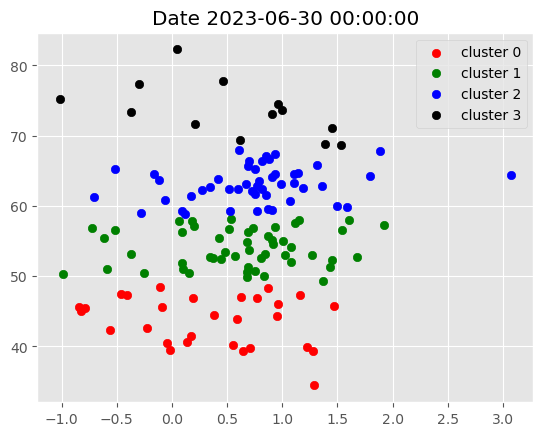

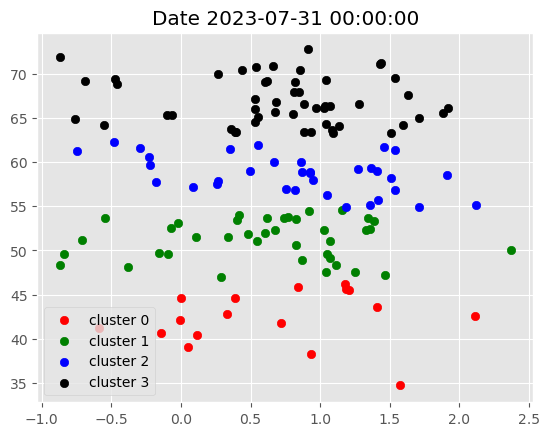

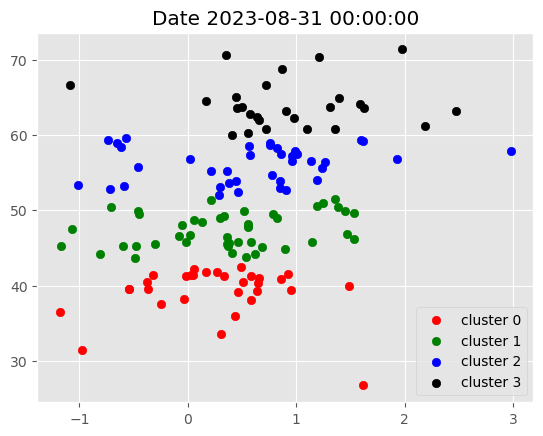

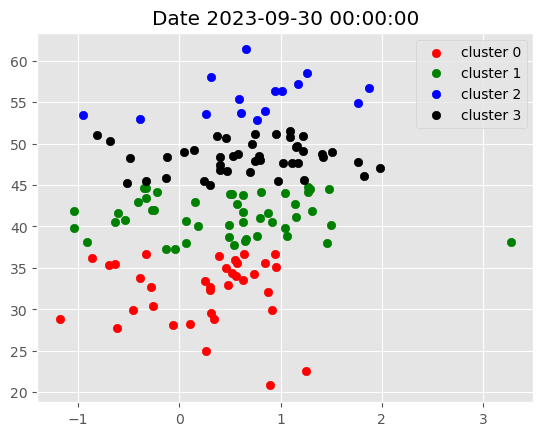

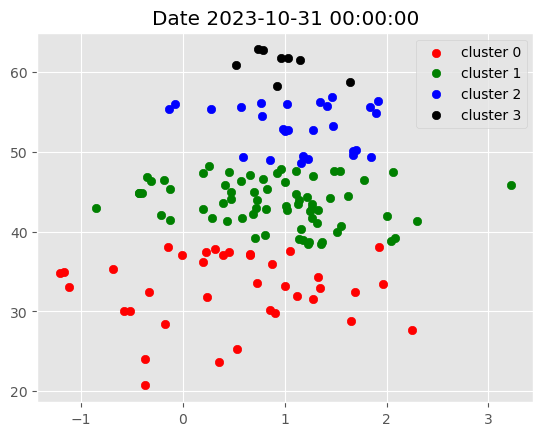

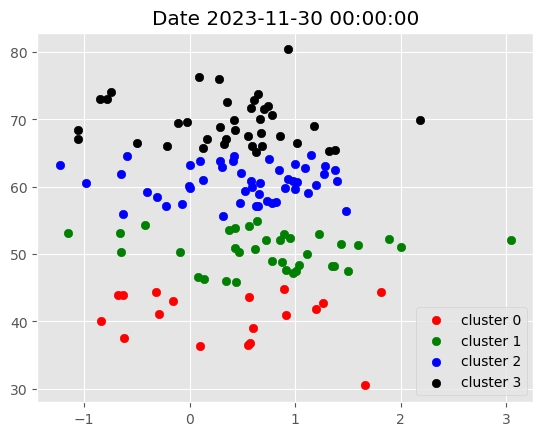

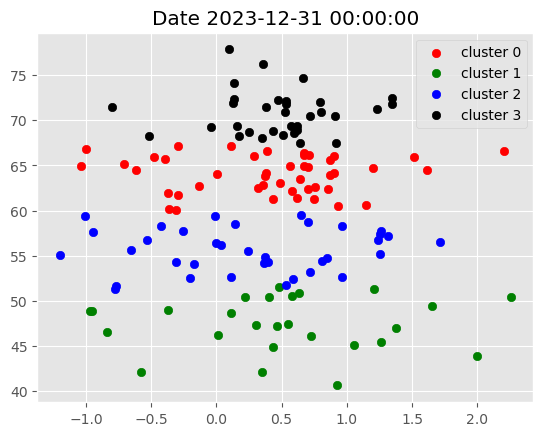

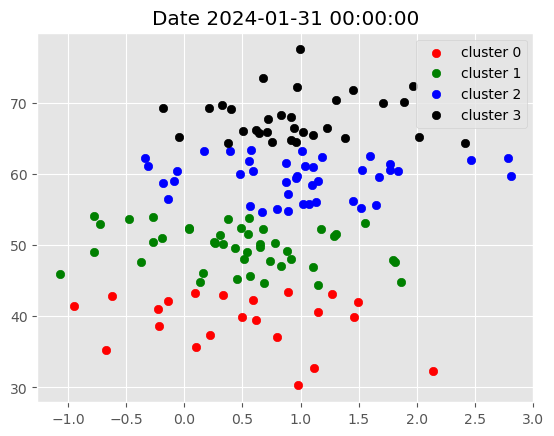

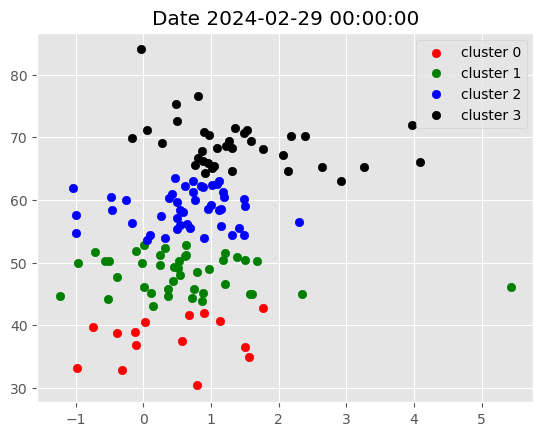

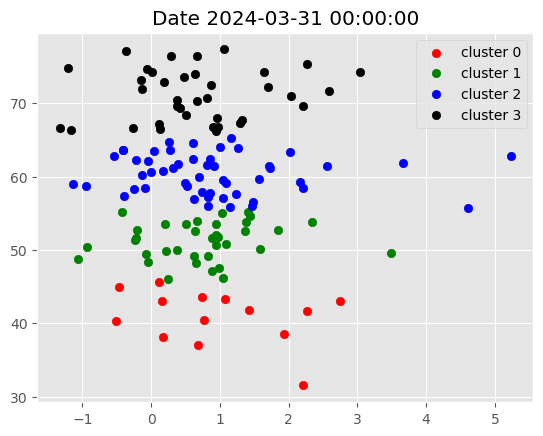

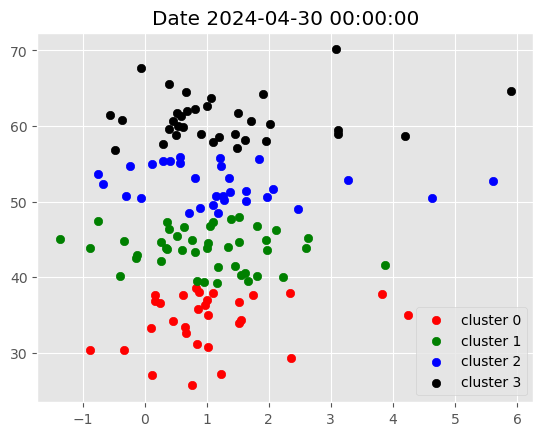

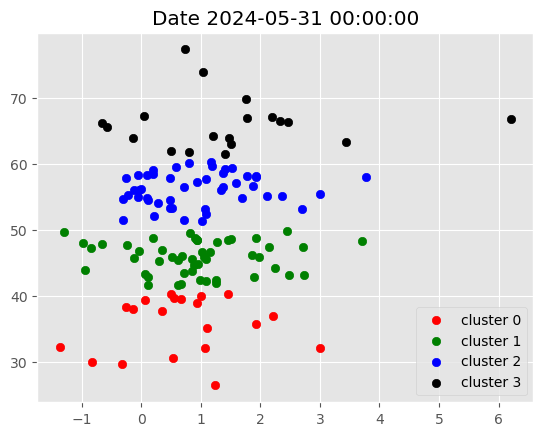

In [440]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [441]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2011-07-01': ['ACN',
  'AMZN',
  'AXP',
  'BIIB',
  'BMY',
  'EMR',
  'FDX',
  'GEN',
  'HAL',
  'IBM',
  'ISRG',
  'KO',
  'LMT',
  'MA',
  'MCD',
  'MDLZ',
  'MSFT',
  'NKE',
  'NSC',
  'PARA',
  'RTX',
  'SBUX',
  'UNH',
  'V',
  'VTRS'],
 '2011-08-01': ['AAPL',
  'AMZN',
  'GOOG',
  'GOOGL',
  'HAL',
  'IBM',
  'ISRG',
  'LVS',
  'MCD',
  'MSFT',
  'PM',
  'SBUX',
  'TGT',
  'TJX'],
 '2011-09-01': ['AAPL',
  'ABT',
  'AMGN',
  'AMT',
  'AMZN',
  'AXP',
  'BKNG',
  'BMY',
  'CF',
  'CL',
  'DE',
  'ISRG',
  'JNJ',
  'KO',
  'LLY',
  'LVS',
  'MA',
  'MCD',
  'MDLZ',
  'MO',
  'MOS',
  'MSFT',
  'NEM',
  'PG',
  'TGT',
  'V',
  'WMT',
  'WYNN',
  'YUM'],
 '2011-10-01': ['AIG',
  'AKAM',
  'AMAT',
  'AMD',
  'AXP',
  'BAC',
  'BK',
  'BKNG',
  'C',
  'CAT',
  'CMI',
  'COF',
  'CRM',
  'CSX',
  'CVS',
  'DD',
  'DE',
  'DIS',
  'DVN',
  'EMR',
  'F',
  'FDX',
  'GLW',
  'GS',
  'HES',
  'HIG',
  'HPQ',
  'ITW',
  'JPM',
  'LVS',
  'MET',
  'MGM',
  'MMM',
  'MRO',
  'MS',
  'MU',
  

In [442]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [443]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  197 of 197 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2010-06-30   8.117004    7.724693         NaN   17.257856   30.556438   
2010-07-01   8.154712    7.631024         NaN   17.139809   30.263916   
2010-07-02   7.721052    7.583732         NaN   17.139809   29.995123   
2010-07-06   7.617351    7.635633         NaN   17.224657   30.366699   
2010-07-07   8.786352    7.943968         NaN   17.600945   31.038706   
...               ...         ...         ...         ...         ...   
2024-05-23  13.820000  186.880005  158.259995  104.230003  305.929993   
2024-05-24  13.840000  189.979996  157.059998  103.949997  300.989990   
2024-05-28  13.440000  189.990005  155.339996  101.949997  297.730011   
2024-05-29  11.620000  190.289993  154.789993  100.730003  293.769989   
2024-05-30  11.440000  191.289993  156.309998  101.739998  284.799988   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AFL  ...   
Date                                                                   ...   
2010-06-30   26.430000   21.147585   27.003359   24.360001  15.961277  ...   
2010-07-01   26.660000   21.193130   26.634466   24.570000  16.200680  ...   
2010-07-02   26.730000   21.155176   26.446669   24.309999  16.129606  ...   
2010-07-06   26.340000   21.170351   26.433254   24.049999  16.294201  ...   
2010-07-07   26.790001   22.346909   26.969837   24.730000  17.008654  ...   
...                ...         ...         ...         ...        ...  ...   
2024-05-23  483.309998  234.559998  251.490005  215.160004  86.779999  ...   
2024-05-24  475.429993  232.509995  248.899994  214.889999  87.690002  ...   
2024-05-28  478.429993  233.440002  243.300003  210.449997  87.260002  ...   
2024-05-29  477.600006  228.149994  240.089996  208.509995  87.180000  ...   
2024-05-30  445.869995  230.000000  240.910004  199.929993  87.980003  ...   

Price         Volume                                                   \
Ticker          VTRS        VZ       WBA      WDC       WFC       WMB   
Date                                                                    
2010-06-30  12276500  29439198  11880100  6184400  37501000   9527110   
2010-07-01   9867000  32420041  15035200  7992600  58947800  14321394   
2010-07-02   5558500  25574500  12016400  4556600  32231100   8865554   
2010-07-06   7359300  39477900  12703100  4856700  37248300  10147571   
2010-07-07   6787400  20717700  10504600  5297700  48830500  13413027   
...              ...       ...       ...      ...       ...       ...   
2024-05-23   7970000  14105000  16012300  5393000  13056100   5879900   
2024-05-24   4900200  10418800  10541200  2743100   9912500   4226000   
2024-05-28   6165800  15071300  20137100  4779100  11276300   5163000   
2024-05-29   5739800  17652000  21387700  7524500  12835000   3977700   
2024-05-30   5823100  19636500  12134300  6287400  13584800   3774500   

Price                                             
Ticker           WMT     WYNN       XOM      YUM  
Date                                              
2010-06-30  55166400  3424700  43944900  6687789  
2010-07-01  54343200  3886500  47746400  7388297  
2010-07-02  40743900  2525000  32767900  4930121  
2010-07-06  54676800  2301300  36912100  7066836  
2010-07-07  48528600  2754300  41797200  5881009  
...              ...      ...       ...      ...  
2024-05-23  16222900  1465100  15979800  1621400  
2024-05-24  11793800  1035400  12211400  1453200  
2024-05-28  13349600  1812400  13978300  1921600  
2024-05-29  11538600  2367700  13902000  1462100  
2024-05-30  13053500  1219100  14692000  1587600  

[3503 rows x 1182 columns]

In [444]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=1)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2011-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2012-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2013-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights

Strategy Return
date                       
2011-07-01         0.015935
2011-07-05         0.001308
2011-07-06         0.002411
2011-07-07        -0.000098
2011-07-08        -0.004477
...                     ...
2024-05-23        -0.006958
2024-05-24         0.003565
2024-05-28        -0.007323
2024-05-29        -0.013458
2024-05-30         0.005514

[3249 rows x 1 columns]

In [445]:
spy = yf.download(tickers='SPY',
                  start='2010-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2011-07-01         0.015935      0.014668
2011-07-05         0.001308     -0.000821
2011-07-06         0.002411      0.001195
2011-07-07        -0.000098      0.010322
2011-07-08        -0.004477     -0.007118
...                     ...           ...
2024-05-23        -0.006958     -0.007331
2024-05-24         0.003565      0.006595
2024-05-28        -0.007323      0.000699
2024-05-29        -0.013458     -0.007027
2024-05-30         0.005514     -0.006656

[3249 rows x 2 columns]

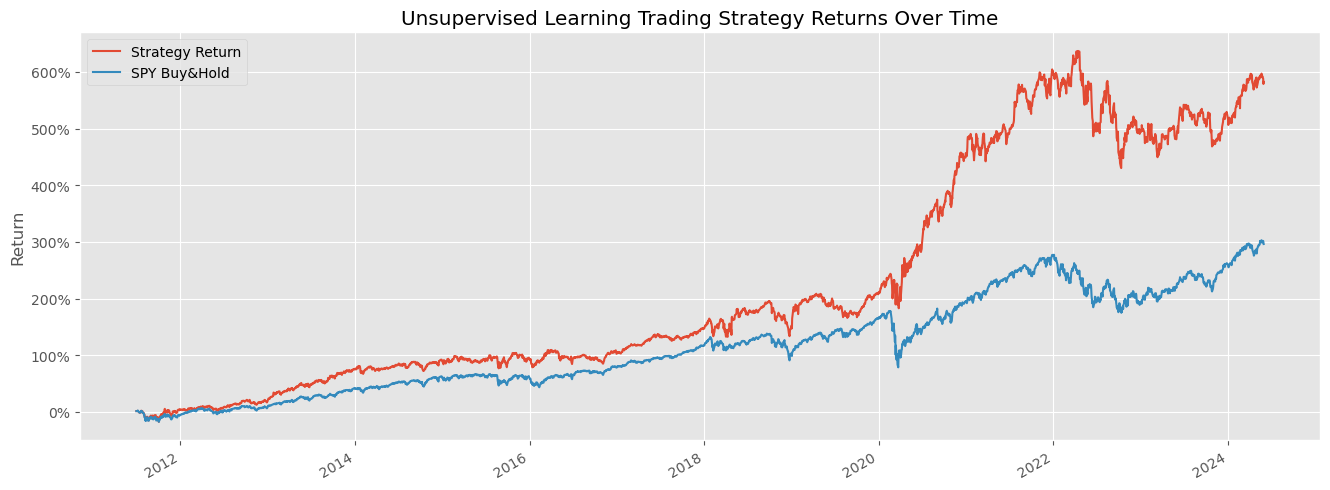

In [446]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-06-01'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()